In [8]:
from abc import ABC, abstractmethod
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import scipy.sparse as sp
import plotly.graph_objects as go
from matplotlib import cm

In [9]:
class Agent(ABC):

    @abstractmethod
    def observe(self, state, action, next_state, reward):
        pass

    @abstractmethod
    def select_action(self, state):
        pass
    
    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def train(self, episodes, debug_mode=False):
        pass

    def __init__(self, id, env):
        self.id = id
        self.env = env
                

In [10]:
discr_step = np.array([0.025, 0.005])
env = gym.make('MountainCar-v0')
(env.observation_space.high - env.observation_space.low)//discr_step

array([72., 28.])

In [14]:
class DynaAgent(Agent):
    
    def __init__(self, id, env=gym.make('MountainCar-v0'), epsilonMax = 0.9, epsilonMin = 0.05, discr_step = np.array([0.025, 0.02]), gamma = 0.99, k=0, k_fixed = True, observation_SIZE = 6, replay_buffer_SIZE = 10000):
        Agent.__init__(self,id,env)
        self.discr_step = discr_step
        self.n_xbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        print(self.n_xbins)
        self.n_vbins = np.round(((self.env.observation_space.high - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        print(self.n_vbins)
        self.n_states = self.n_xbins*self.n_vbins
        self.n_actions = 3
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        self.k = k
        self.k_fixed = k_fixed
        self.terminal_x_bin = self.discretize_x(0.5)*self.n_vbins
        
        '''
        Definition for the plots
        '''        
        self.max_x = -2 
        self.min_x = 1 
        self.max_v = -0.1
        self.min_v = 0.1
        self.time_episodes = []
        self.visited_states = []
        self.important_episodes = []
        self.auxiliary_reward_ep = 0
        self.auxiliary_reward = []
        self.episodesHistory = []
        self.success_episodes = []
        self.mean_Q_evolution = []
            
        '''
        Definition of the replay buffer
        '''
        self.replay_buffer_SIZE = replay_buffer_SIZE
        self.observation_SIZE = observation_SIZE
        self.visited_state_action_Array = np.zeros((replay_buffer_SIZE,observation_SIZE))
        self.visited_state_action = set()
        
        self.N = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        self.P = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        for i in range(self.n_states):
            for j in range(self.n_actions):
                random = np.random.rand(self.n_states)
                self.P[i, j, :] = random/random.sum()
        
        self.R = - np.ones(shape=(self.n_states, self.n_actions))
        for state in range(self.terminal_x_bin, self.n_states):
            self.R[state, :] = 0
        
        self.Q = np.zeros(shape=(self.n_states, self.n_actions))

    
    def discretize_x(self, x):
        x_bin = np.round(((x - self.env.observation_space.low)/self.discr_step)[0]).astype(np.int32)
        return x_bin

    def discretize_v(self, v):
        v_bin = np.round(((v - self.env.observation_space.low)/self.discr_step)[1]).astype(np.int32)
        return v_bin 

    def discretize(self, state):
        x_bin = self.discretize_x(state[0])
        v_bin = self.discretize_v(state[1])
        return x_bin*self.n_vbins + v_bin

    
   
    def update(self, state, action, next_state, reward):
        start_time = time.time()
        discr_state, discr_next_state = self.discretize(state), self.discretize(next_state)

        self.visited_states.append(state)
        self.visited_state_action.add((discr_state,action))
        self.N[discr_state,action, discr_next_state] += 1

        
        total_visited = self.N[discr_state,action,:].sum()

        if total_visited > 0:
            self.P[discr_state, action, :] = self.N[discr_state, action,  :] / total_visited
            self.R[discr_state, action] = (self.R[discr_state, action]*(total_visited-1) + reward) / total_visited

        self.auxiliary_reward_ep += self.R[discr_state, action]

        if discr_state < self.terminal_x_bin:
            self.Q[discr_state, action] = reward + (self.gamma)*(self.P[discr_state, action,:]*np.max(self.Q, axis = 1)[:]).sum()
        else:
            self.Q[discr_state, action] = reward
        
        if not self.k_fixed:
            self.k = len(self.visited_state_action) // 10
            print("K changes")
            
        sampled_states = []
        if self.k >= 1:
            sampled_states = random.choices(list(self.visited_state_action), k = self.k)

            for (random_state, random_action) in sampled_states:
                if random_state < self.terminal_x_bin:
                    self.Q[random_state, random_action] = self.R[random_state, random_action] + (self.gamma)*(self.P[random_state, random_action,:]*np.max(self.Q, axis = 1)[:]).sum()
                else:
                    self.Q[random_state, random_action] = self.R[random_state, random_action]

        #print(time.time() - start_time)

    def observe(self):
        pass
    
    def select_action(self, state):
        state_bin = self.discretize(state)
        p = random.uniform(0,1)
        a=0
        if p < 1-self.epsilon :
            a = np.argmax(self.Q[state_bin,:])
        else:
            a = random.randint(0,2)
            
        return a

    
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        state_bin = self.discretize(state)
        return np.argmax(self.Q[state_bin,:])

    
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seed = False):
        newSeed = random.randint(0,100000)
        
        if seed != False:
            newSeed = seed
            
        state,_ = self.env.reset(seed = newSeed)
        done = False
                    
        while done == False:
                                        
            action = self.select_best_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            state = next_state
            done = terminated or truncated
        self.env.close()

    """
    # Reinitialisation de R nécessaire ?
    def reset_for_episode(self):
        self.N_episode = np.zeros(shape=(self.n_states, self.n_actions, self.n_states))
        
        self.W_episode = - np.ones(shape=(self.n_states, self.n_actions))
        terminal_x_bin = self.discretize_x(0.5)
        for state in range(terminal_x_bin, self.n_states):
            self.W_episode[state, :] = 0

    """  

    
    def train(self, episodes, debug_mode=True, epsilon_decrease=True, epsilonDecreasing=100):
        
        self.episodesHistory = np.zeros((episodes))
        
        for i in tqdm(range(episodes)):
            start_time = time.time()
            if epsilon_decrease: 
                if self.epsilon > self.epsilonMin:
                    self.epsilon = self.epsilonMax*math.exp(-i/epsilonDecreasing)
            else:
                self.epsilon = self.epsilonMax
                
            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            
            done = False
            episode_reward = 0
            actual_episode_for_Q = []
            
            while not done:
                if self.max_x < state[0]:
                    self.max_x = state[0]
                if self.min_x > state[0]:
                    self.min_x = state[0]

                if self.max_v < state[1]:
                    self.max_v = state[1]
                if self.min_v > state[1]:
                    self.min_v = state[1]
                    
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                self.update(state, action, next_state, reward)
                start = time.time()
                discr_state = self.discretize(state)
                max_value = np.max(self.Q[discr_state, :])
                actual_episode_for_Q.append((state, max_value))
                                             
                episode_reward += reward
                state = next_state
                done = terminated or truncated

            stop_time = time.time()
            episode_time = stop_time-start_time

            self.auxiliary_reward.append(self.auxiliary_reward_ep)
            self.auxiliary_reward_ep = 0
            
            self.time_episodes.append(episode_time)
            if (i%500 == 0):  # episodes marquants considérés : tous les 500 eps, ou quand ça se termine
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward))
            if terminated:
                print("Terminated")
                self.important_episodes.append((actual_episode_for_Q, episode_time, episode_reward))
                self.success_episodes.append(1)
            else:
                self.success_episodes.append(0)

            mean_max_q = np.sum([value[1] for value in actual_episode_for_Q]) / (-episode_reward)
            self.mean_Q_evolution.append(mean_max_q)
                
            if debug_mode: print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            self.episodesHistory[i] = episode_reward
        return 

    def three_dimensions_Q_plot(self, with_important_episodes = False):
    
        list_states = self.visited_states
        x = np.array([state[0] for state in list_states])
        v = np.array([state[1] for state in list_states])

        discretized_states = [self.discretize(state) for state in list_states]
        max_q_values = [max(self.Q[discr_state, :]) for discr_state in discretized_states]

    
        fig = go.Figure(data=[go.Scatter3d(
            x=x,
            y=v,
            z=max_q_values,
            mode='markers',
            marker=dict(
                size=5,
                color=max_q_values,  
                colorscale='Viridis',
                colorbar=dict(
                title='Q_max Values',
                    height=300
                ),
            opacity=0.8
            )
        )])


        if with_important_episodes:

            states_ep = [value[0] for value in self.important_episodes]

            for state_ep in states_ep:
                x_ep = [state[0][0] for state in state_ep]
                v_ep = [state[0][1] for state in state_ep]
                max_q_ep = [state[1] for state in state_ep]
            
                fig.add_trace(go.Scatter3d(
                    x=x_ep,
                    y=v_ep,
                    z=max_q_ep,
                    mode='lines',  
                    line=dict(
                        color='black', 
                        width=6
                    )
                ))

            

        fig.update_layout(
            title='Max Q(s,a) as a function of s = (x, v)',
            autosize=False,
            width=1000, 
            height=800,  
            margin=dict(l=65, r=50, b=65, t=90),
            scene=dict(
                xaxis_title='Values of x',
                yaxis_title='Values of v',
                zaxis_title='Values of Q_max'
            ),
            legend_title_text='Trajectories'
        )


        fig.show()




    def two_dimensions_Q_plot(self, with_important_episodes = False):
    
        list_states = self.visited_states
        discretized_states = [self.discretize(state) for state in list_states]

        X = np.array([state[0] for state in list_states])
        V = np.array([state[1] for state in list_states])
        Q = [max(self.Q[discr_state, :]) for discr_state in discretized_states]
        
        # Normalisation des valeurs Q pour le colormap
        Q_normalized = (Q - np.min(Q)) / (np.max(Q) - np.min(Q))

        cmap = cm.get_cmap('coolwarm')
        color = cmap(Q_normalized)

        if not with_important_episodes:

            fig, ax = plt.subplots()


            plt.scatter(X,V,c=color, s=1)

            sc = ax.scatter(X, V, c=color, s=2, cmap=cmap, edgecolors='none')
            ax.legend()
            ax.set_xlabel('Values of x')
            ax.set_ylabel('Values of v')
            ax.set_title('Max Q(s,a) as a function of s = (x, v) in 2D')

            plt.colorbar(sc, label='Normalized Q values')
            plt.show()

        else :

            states_ep = [value[0] for value in self.important_episodes]
            nb = 0
            
            for state_ep in states_ep:

                fig, ax = plt.subplots()
                plt.scatter(X,V,c=color, s=1)

                sc = ax.scatter(X, V, c=color, s=2, cmap=cmap, edgecolors='none')
                plt.colorbar(sc, label='Normalized Q values')
        
                x_ep = [state[0][0] for state in state_ep]
                v_ep = [state[0][1] for state in state_ep]
                #max_q_ep = [state[1] for state in state_ep]

                nb+=1
                
                ax.scatter(x_ep, v_ep, color='black', s=2, label=f'Important Episode number: {nb}')
                ax.plot(x_ep, v_ep, color='black', linewidth=1)

                ax.legend()
                ax.set_xlabel('Values of x')
                ax.set_ylabel('Values of v')
                ax.set_title('Max Q(s,a) as a function of s = (x, v) in 2D')

                plt.show()




In [16]:
A = DynaAgent("id0", k = 200)
A.train(1000, debug_mode=True)

72
7


  0%|          | 1/1000 [00:00<12:19,  1.35it/s]

Episode 1 , Reward: -200.0 Epsilon: 0.9


  0%|          | 2/1000 [00:01<12:11,  1.36it/s]

Episode 2 , Reward: -200.0 Epsilon: 0.8910448503742513


  0%|          | 3/1000 [00:02<12:04,  1.38it/s]

Episode 3 , Reward: -200.0 Epsilon: 0.8821788059760798


  0%|          | 4/1000 [00:02<12:21,  1.34it/s]

Episode 4 , Reward: -200.0 Epsilon: 0.8734009801936573


  0%|          | 5/1000 [00:03<12:25,  1.34it/s]

Episode 5 , Reward: -200.0 Epsilon: 0.8647104952370909


  1%|          | 6/1000 [00:04<12:38,  1.31it/s]

Episode 6 , Reward: -200.0 Epsilon: 0.8561064820506427


  1%|          | 7/1000 [00:05<13:05,  1.26it/s]

Episode 7 , Reward: -200.0 Epsilon: 0.8475880802258239


  1%|          | 8/1000 [00:06<13:36,  1.22it/s]

Episode 8 , Reward: -200.0 Epsilon: 0.8391544379153535


  1%|          | 9/1000 [00:07<14:19,  1.15it/s]

Episode 9 , Reward: -200.0 Epsilon: 0.8308047117479722


  1%|          | 10/1000 [00:08<15:15,  1.08it/s]

Episode 10 , Reward: -200.0 Epsilon: 0.8225380667441053


  1%|          | 11/1000 [00:09<15:46,  1.04it/s]

Episode 11 , Reward: -200.0 Epsilon: 0.8143536762323635


  1%|          | 12/1000 [00:10<14:51,  1.11it/s]

Episode 12 , Reward: -200.0 Epsilon: 0.8062507217668754


  1%|▏         | 13/1000 [00:10<13:54,  1.18it/s]

Episode 13 , Reward: -200.0 Epsilon: 0.7982283930454418


  1%|▏         | 14/1000 [00:11<13:16,  1.24it/s]

Episode 14 , Reward: -200.0 Epsilon: 0.7902858878285052


  2%|▏         | 15/1000 [00:12<12:53,  1.27it/s]

Episode 15 , Reward: -200.0 Epsilon: 0.7824224118589252


  2%|▏         | 16/1000 [00:12<12:31,  1.31it/s]

Episode 16 , Reward: -200.0 Epsilon: 0.774637178782552


  2%|▏         | 17/1000 [00:13<12:21,  1.33it/s]

Episode 17 , Reward: -200.0 Epsilon: 0.7669294100695903


  2%|▏         | 18/1000 [00:14<12:14,  1.34it/s]

Episode 18 , Reward: -200.0 Epsilon: 0.7592983349367454


  2%|▏         | 19/1000 [00:15<12:09,  1.34it/s]

Episode 19 , Reward: -200.0 Epsilon: 0.7517431902701448


  2%|▏         | 20/1000 [00:15<12:05,  1.35it/s]

Episode 20 , Reward: -200.0 Epsilon: 0.744263220549026


  2%|▏         | 21/1000 [00:16<12:03,  1.35it/s]

Episode 21 , Reward: -200.0 Epsilon: 0.7368576777701836


  2%|▏         | 22/1000 [00:17<11:55,  1.37it/s]

Episode 22 , Reward: -200.0 Epsilon: 0.7295258213731683


  2%|▏         | 23/1000 [00:18<12:00,  1.36it/s]

Episode 23 , Reward: -200.0 Epsilon: 0.7222669181662307


  2%|▏         | 24/1000 [00:18<11:53,  1.37it/s]

Episode 24 , Reward: -200.0 Epsilon: 0.7150802422530007


  2%|▎         | 25/1000 [00:19<12:02,  1.35it/s]

Episode 25 , Reward: -200.0 Epsilon: 0.7079650749598981


  3%|▎         | 26/1000 [00:20<12:00,  1.35it/s]

Episode 26 , Reward: -200.0 Epsilon: 0.7009207047642644


  3%|▎         | 27/1000 [00:21<11:51,  1.37it/s]

Episode 27 , Reward: -200.0 Epsilon: 0.6939464272232096


  3%|▎         | 28/1000 [00:21<11:45,  1.38it/s]

Episode 28 , Reward: -200.0 Epsilon: 0.6870415449031678


  3%|▎         | 29/1000 [00:22<11:42,  1.38it/s]

Episode 29 , Reward: -200.0 Epsilon: 0.6802053673101529


  3%|▎         | 30/1000 [00:23<12:48,  1.26it/s]

Episode 30 , Reward: -200.0 Epsilon: 0.6734372108207087


  3%|▎         | 31/1000 [00:24<14:01,  1.15it/s]

Episode 31 , Reward: -200.0 Epsilon: 0.666736398613546


  3%|▎         | 32/1000 [00:25<14:25,  1.12it/s]

Episode 32 , Reward: -200.0 Epsilon: 0.6601022606018603


  3%|▎         | 33/1000 [00:26<13:33,  1.19it/s]

Episode 33 , Reward: -200.0 Epsilon: 0.6535341333663218


  3%|▎         | 34/1000 [00:26<12:52,  1.25it/s]

Episode 34 , Reward: -200.0 Epsilon: 0.6470313600887335


  4%|▎         | 35/1000 [00:27<12:37,  1.27it/s]

Episode 35 , Reward: -200.0 Epsilon: 0.6405932904863487


  4%|▎         | 36/1000 [00:28<12:26,  1.29it/s]

Episode 36 , Reward: -200.0 Epsilon: 0.6342192807468421


  4%|▎         | 37/1000 [00:29<12:09,  1.32it/s]

Episode 37 , Reward: -200.0 Epsilon: 0.627908693463928


  4%|▍         | 38/1000 [00:29<12:02,  1.33it/s]

Episode 38 , Reward: -200.0 Epsilon: 0.6216608975736192


  4%|▍         | 39/1000 [00:30<11:58,  1.34it/s]

Episode 39 , Reward: -200.0 Epsilon: 0.6154752682911203


  4%|▍         | 40/1000 [00:31<11:45,  1.36it/s]

Episode 40 , Reward: -200.0 Epsilon: 0.6093511870483482


  4%|▍         | 41/1000 [00:31<11:46,  1.36it/s]

Episode 41 , Reward: -200.0 Epsilon: 0.6032880414320754


  4%|▍         | 42/1000 [00:32<11:40,  1.37it/s]

Episode 42 , Reward: -200.0 Epsilon: 0.5972852251226874


  4%|▍         | 43/1000 [00:33<11:31,  1.38it/s]

Episode 43 , Reward: -200.0 Epsilon: 0.591342137833551


  4%|▍         | 44/1000 [00:34<11:32,  1.38it/s]

Episode 44 , Reward: -200.0 Epsilon: 0.5854581852509849


  4%|▍         | 45/1000 [00:34<11:30,  1.38it/s]

Episode 45 , Reward: -200.0 Epsilon: 0.5796327789748272


  5%|▍         | 46/1000 [00:35<11:24,  1.39it/s]

Episode 46 , Reward: -200.0 Epsilon: 0.573865336459596


  5%|▍         | 47/1000 [00:36<11:32,  1.38it/s]

Episode 47 , Reward: -200.0 Epsilon: 0.5681552809562334


  5%|▍         | 48/1000 [00:37<11:32,  1.38it/s]

Episode 48 , Reward: -200.0 Epsilon: 0.5625020414544307


  5%|▍         | 49/1000 [00:37<11:26,  1.38it/s]

Episode 49 , Reward: -200.0 Epsilon: 0.5569050526255268


  5%|▌         | 50/1000 [00:38<11:33,  1.37it/s]

Episode 50 , Reward: -200.0 Epsilon: 0.5513637547659745


  5%|▌         | 51/1000 [00:39<13:04,  1.21it/s]

Episode 51 , Reward: -200.0 Epsilon: 0.5458775937413701


  5%|▌         | 52/1000 [00:40<14:05,  1.12it/s]

Episode 52 , Reward: -200.0 Epsilon: 0.5404460209310393


  5%|▌         | 53/1000 [00:41<14:13,  1.11it/s]

Episode 53 , Reward: -200.0 Epsilon: 0.535068493173175


  5%|▌         | 54/1000 [00:42<13:22,  1.18it/s]

Episode 54 , Reward: -200.0 Epsilon: 0.5297444727105197


  6%|▌         | 55/1000 [00:42<12:44,  1.24it/s]

Episode 55 , Reward: -200.0 Epsilon: 0.5244734271365907


  6%|▌         | 56/1000 [00:43<12:17,  1.28it/s]

Episode 56 , Reward: -200.0 Epsilon: 0.519254829342438


  6%|▌         | 57/1000 [00:44<12:02,  1.31it/s]

Episode 57 , Reward: -200.0 Epsilon: 0.5140881574639334


  6%|▌         | 58/1000 [00:45<11:52,  1.32it/s]

Episode 58 , Reward: -200.0 Epsilon: 0.5089728948295834


  6%|▌         | 59/1000 [00:45<11:50,  1.32it/s]

Episode 59 , Reward: -200.0 Epsilon: 0.5039085299088618


  6%|▌         | 60/1000 [00:46<11:43,  1.34it/s]

Episode 60 , Reward: -200.0 Epsilon: 0.4988945562610564


  6%|▌         | 61/1000 [00:47<11:30,  1.36it/s]

Episode 61 , Reward: -200.0 Epsilon: 0.49393047248462385


  6%|▌         | 62/1000 [00:48<11:29,  1.36it/s]

Episode 62 , Reward: -200.0 Epsilon: 0.48901578216704983


  6%|▋         | 63/1000 [00:48<11:32,  1.35it/s]

Episode 63 , Reward: -200.0 Epsilon: 0.484149993835207


  6%|▋         | 64/1000 [00:49<11:35,  1.35it/s]

Episode 64 , Reward: -200.0 Epsilon: 0.4793326209062075


  6%|▋         | 65/1000 [00:50<11:31,  1.35it/s]

Episode 65 , Reward: -200.0 Epsilon: 0.4745631816387437


  7%|▋         | 66/1000 [00:50<11:25,  1.36it/s]

Episode 66 , Reward: -200.0 Epsilon: 0.46984119908491445


  7%|▋         | 67/1000 [00:51<11:19,  1.37it/s]

Episode 67 , Reward: -200.0 Epsilon: 0.46516620104252926


  7%|▋         | 68/1000 [00:52<11:26,  1.36it/s]

Episode 68 , Reward: -200.0 Epsilon: 0.46053772000788823


  7%|▋         | 69/1000 [00:53<11:15,  1.38it/s]

Episode 69 , Reward: -200.0 Epsilon: 0.4559552931290306


  7%|▋         | 70/1000 [00:53<11:13,  1.38it/s]

Episode 70 , Reward: -200.0 Epsilon: 0.45141846215945003


  7%|▋         | 71/1000 [00:54<11:42,  1.32it/s]

Episode 71 , Reward: -200.0 Epsilon: 0.4469267734122686


  7%|▋         | 72/1000 [00:55<12:53,  1.20it/s]

Episode 72 , Reward: -200.0 Epsilon: 0.4424797777148686


  7%|▋         | 73/1000 [00:56<13:34,  1.14it/s]

Episode 73 , Reward: -200.0 Epsilon: 0.4380770303639745


  7%|▋         | 74/1000 [00:57<13:40,  1.13it/s]

Episode 74 , Reward: -200.0 Epsilon: 0.4337180910811822


  8%|▊         | 75/1000 [00:58<13:02,  1.18it/s]

Episode 75 , Reward: -200.0 Epsilon: 0.42940252396893097


  8%|▊         | 76/1000 [00:59<12:36,  1.22it/s]

Episode 76 , Reward: -200.0 Epsilon: 0.4251298974669132


  8%|▊         | 77/1000 [00:59<12:16,  1.25it/s]

Episode 77 , Reward: -200.0 Epsilon: 0.42089978430891833


  8%|▊         | 78/1000 [01:00<12:01,  1.28it/s]

Episode 78 , Reward: -200.0 Epsilon: 0.41671176148010525


  8%|▊         | 79/1000 [01:01<11:41,  1.31it/s]

Episode 79 , Reward: -200.0 Epsilon: 0.41256541017470116


  8%|▊         | 80/1000 [01:02<11:33,  1.33it/s]

Episode 80 , Reward: -200.0 Epsilon: 0.40846031575412023


  8%|▊         | 81/1000 [01:02<11:32,  1.33it/s]

Episode 81 , Reward: -200.0 Epsilon: 0.4043960677054994


  8%|▊         | 82/1000 [01:03<11:25,  1.34it/s]

Episode 82 , Reward: -200.0 Epsilon: 0.400372259600647


  8%|▊         | 83/1000 [01:04<11:21,  1.34it/s]

Episode 83 , Reward: -200.0 Epsilon: 0.39638848905539936


  8%|▊         | 84/1000 [01:04<11:10,  1.37it/s]

Episode 84 , Reward: -200.0 Epsilon: 0.3924443576893821


  8%|▊         | 85/1000 [01:05<11:13,  1.36it/s]

Episode 85 , Reward: -200.0 Epsilon: 0.38853947108617176


  9%|▊         | 86/1000 [01:06<11:10,  1.36it/s]

Episode 86 , Reward: -200.0 Epsilon: 0.38467343875385407


  9%|▊         | 87/1000 [01:07<11:10,  1.36it/s]

Episode 87 , Reward: -200.0 Epsilon: 0.3808458740859739


  9%|▉         | 88/1000 [01:07<11:10,  1.36it/s]

Episode 88 , Reward: -200.0 Epsilon: 0.37705639432287513


  9%|▉         | 89/1000 [01:08<11:18,  1.34it/s]

Episode 89 , Reward: -200.0 Epsilon: 0.3733046205134232


  9%|▉         | 90/1000 [01:09<11:19,  1.34it/s]

Episode 90 , Reward: -200.0 Epsilon: 0.369590177477111


  9%|▉         | 91/1000 [01:10<11:15,  1.35it/s]

Episode 91 , Reward: -200.0 Epsilon: 0.36591269376653923


  9%|▉         | 92/1000 [01:11<11:53,  1.27it/s]

Episode 92 , Reward: -200.0 Epsilon: 0.3622718016302724


  9%|▉         | 93/1000 [01:12<13:00,  1.16it/s]

Episode 93 , Reward: -200.0 Epsilon: 0.35866713697606273


  9%|▉         | 94/1000 [01:13<13:37,  1.11it/s]

Episode 94 , Reward: -200.0 Epsilon: 0.35509833933444096


 10%|▉         | 95/1000 [01:13<12:59,  1.16it/s]

Episode 95 , Reward: -200.0 Epsilon: 0.351565051822669


 10%|▉         | 96/1000 [01:14<12:24,  1.21it/s]

Episode 96 , Reward: -200.0 Epsilon: 0.34806692110905113


 10%|▉         | 97/1000 [01:15<12:07,  1.24it/s]

Episode 97 , Reward: -200.0 Epsilon: 0.3446035973776009


 10%|▉         | 98/1000 [01:16<11:42,  1.28it/s]

Episode 98 , Reward: -200.0 Epsilon: 0.34117473429305895


 10%|▉         | 99/1000 [01:16<11:35,  1.30it/s]

Episode 99 , Reward: -200.0 Epsilon: 0.3377799889662596


 10%|█         | 100/1000 [01:17<11:23,  1.32it/s]

Episode 100 , Reward: -200.0 Epsilon: 0.33441902191984113


 10%|█         | 101/1000 [01:18<11:15,  1.33it/s]

Episode 101 , Reward: -200.0 Epsilon: 0.33109149705429813


 10%|█         | 102/1000 [01:19<11:14,  1.33it/s]

Episode 102 , Reward: -200.0 Epsilon: 0.327797081614371


 10%|█         | 103/1000 [01:19<11:14,  1.33it/s]

Episode 103 , Reward: -200.0 Epsilon: 0.32453544615577046


 10%|█         | 104/1000 [01:20<11:12,  1.33it/s]

Episode 104 , Reward: -200.0 Epsilon: 0.32130626451223265


 10%|█         | 105/1000 [01:21<11:02,  1.35it/s]

Episode 105 , Reward: -200.0 Epsilon: 0.31810921376290213


 11%|█         | 106/1000 [01:22<11:00,  1.35it/s]

Episode 106 , Reward: -200.0 Epsilon: 0.3149439742000398


 11%|█         | 107/1000 [01:22<10:59,  1.35it/s]

Episode 107 , Reward: -200.0 Epsilon: 0.31181022929705166


 11%|█         | 108/1000 [01:23<11:00,  1.35it/s]

Episode 108 , Reward: -200.0 Epsilon: 0.308707665676836


 11%|█         | 109/1000 [01:24<10:58,  1.35it/s]

Episode 109 , Reward: -200.0 Epsilon: 0.3056359730804452


 11%|█         | 110/1000 [01:25<11:09,  1.33it/s]

Episode 110 , Reward: -200.0 Epsilon: 0.30259484433606004


 11%|█         | 111/1000 [01:25<10:59,  1.35it/s]

Episode 111 , Reward: -200.0 Epsilon: 0.2995839753282716


 11%|█         | 112/1000 [01:26<11:01,  1.34it/s]

Episode 112 , Reward: -200.0 Epsilon: 0.29660306496767014


 11%|█▏        | 113/1000 [01:27<12:29,  1.18it/s]

Episode 113 , Reward: -200.0 Epsilon: 0.2936518151607355


 11%|█▏        | 114/1000 [01:28<13:20,  1.11it/s]

Episode 114 , Reward: -200.0 Epsilon: 0.2907299307800277


 12%|█▏        | 115/1000 [01:29<13:41,  1.08it/s]

Episode 115 , Reward: -200.0 Epsilon: 0.28783711963467357


 12%|█▏        | 116/1000 [01:30<12:49,  1.15it/s]

Episode 116 , Reward: -200.0 Epsilon: 0.28497309244114793


 12%|█▏        | 117/1000 [01:31<12:11,  1.21it/s]

Episode 117 , Reward: -200.0 Epsilon: 0.2821375627943448


 12%|█▏        | 118/1000 [01:31<11:54,  1.23it/s]

Episode 118 , Reward: -200.0 Epsilon: 0.27933024713893656


 12%|█▏        | 119/1000 [01:32<11:32,  1.27it/s]

Episode 119 , Reward: -200.0 Epsilon: 0.27655086474101814


 12%|█▏        | 120/1000 [01:33<11:18,  1.30it/s]

Episode 120 , Reward: -200.0 Epsilon: 0.27379913766003366


 12%|█▏        | 121/1000 [01:34<11:13,  1.30it/s]

Episode 121 , Reward: -200.0 Epsilon: 0.27107479072098195


 12%|█▏        | 122/1000 [01:34<11:15,  1.30it/s]

Episode 122 , Reward: -200.0 Epsilon: 0.2683775514868987


 12%|█▏        | 123/1000 [01:35<11:02,  1.32it/s]

Episode 123 , Reward: -200.0 Epsilon: 0.2657071502316128


 12%|█▏        | 124/1000 [01:36<11:04,  1.32it/s]

Episode 124 , Reward: -200.0 Epsilon: 0.2630633199127735


 12%|█▎        | 125/1000 [01:37<11:05,  1.32it/s]

Episode 125 , Reward: -200.0 Epsilon: 0.26044579614514557


 13%|█▎        | 126/1000 [01:37<10:57,  1.33it/s]

Episode 126 , Reward: -200.0 Epsilon: 0.25785431717417107


 13%|█▎        | 127/1000 [01:38<10:58,  1.33it/s]

Episode 127 , Reward: -200.0 Epsilon: 0.25528862384979334


 13%|█▎        | 128/1000 [01:39<11:01,  1.32it/s]

Episode 128 , Reward: -200.0 Epsilon: 0.2527484596005418


 13%|█▎        | 129/1000 [01:40<10:57,  1.33it/s]

Episode 129 , Reward: -200.0 Epsilon: 0.25023357040787475


 13%|█▎        | 130/1000 [01:40<10:51,  1.33it/s]

Episode 130 , Reward: -200.0 Epsilon: 0.24774370478077712


 13%|█▎        | 131/1000 [01:41<10:47,  1.34it/s]

Episode 131 , Reward: -200.0 Epsilon: 0.24527861373061133


 13%|█▎        | 132/1000 [01:42<10:45,  1.35it/s]

Episode 132 , Reward: -200.0 Epsilon: 0.24283805074621814


 13%|█▎        | 133/1000 [01:43<11:18,  1.28it/s]

Episode 133 , Reward: -200.0 Epsilon: 0.2404217717692653


 13%|█▎        | 134/1000 [01:44<12:14,  1.18it/s]

Episode 134 , Reward: -200.0 Epsilon: 0.23802953516984157


 14%|█▎        | 135/1000 [01:45<12:52,  1.12it/s]

Episode 135 , Reward: -200.0 Epsilon: 0.2356611017222934


 14%|█▎        | 136/1000 [01:45<12:31,  1.15it/s]

Episode 136 , Reward: -200.0 Epsilon: 0.23331623458130235


 14%|█▎        | 137/1000 [01:46<11:55,  1.21it/s]

Episode 137 , Reward: -200.0 Epsilon: 0.2309946992582003


 14%|█▍        | 138/1000 [01:47<11:32,  1.24it/s]

Episode 138 , Reward: -200.0 Epsilon: 0.22869626359752024


 14%|█▍        | 139/1000 [01:48<11:18,  1.27it/s]

Episode 139 , Reward: -200.0 Epsilon: 0.22642069775378088


 14%|█▍        | 140/1000 [01:48<11:13,  1.28it/s]

Episode 140 , Reward: -200.0 Epsilon: 0.2241677741685014


 14%|█▍        | 141/1000 [01:49<11:07,  1.29it/s]

Episode 141 , Reward: -200.0 Epsilon: 0.22193726754744583


 14%|█▍        | 142/1000 [01:50<10:55,  1.31it/s]

Episode 142 , Reward: -200.0 Epsilon: 0.2197289548380934


 14%|█▍        | 143/1000 [01:51<10:47,  1.32it/s]

Episode 143 , Reward: -200.0 Epsilon: 0.2175426152073328


 14%|█▍        | 144/1000 [01:51<10:37,  1.34it/s]

Episode 144 , Reward: -200.0 Epsilon: 0.2153780300193791


 14%|█▍        | 145/1000 [01:52<10:37,  1.34it/s]

Episode 145 , Reward: -200.0 Epsilon: 0.2132349828139096


 15%|█▍        | 146/1000 [01:53<10:33,  1.35it/s]

Episode 146 , Reward: -200.0 Epsilon: 0.2111132592844179


 15%|█▍        | 147/1000 [01:54<10:31,  1.35it/s]

Episode 147 , Reward: -200.0 Epsilon: 0.20901264725678295


 15%|█▍        | 148/1000 [01:54<10:33,  1.34it/s]

Episode 148 , Reward: -200.0 Epsilon: 0.20693293666805146


 15%|█▍        | 149/1000 [01:55<10:29,  1.35it/s]

Episode 149 , Reward: -200.0 Epsilon: 0.20487391954543147


 15%|█▌        | 150/1000 [01:56<10:27,  1.35it/s]

Episode 150 , Reward: -200.0 Epsilon: 0.20283538998549486


 15%|█▌        | 151/1000 [01:57<10:25,  1.36it/s]

Episode 151 , Reward: -200.0 Epsilon: 0.20081714413358684


 15%|█▌        | 152/1000 [01:57<10:24,  1.36it/s]

Episode 152 , Reward: -200.0 Epsilon: 0.19881898016344038


 15%|█▌        | 153/1000 [01:58<10:23,  1.36it/s]

Episode 153 , Reward: -200.0 Epsilon: 0.19684069825699327


 15%|█▌        | 154/1000 [01:59<11:52,  1.19it/s]

Episode 154 , Reward: -200.0 Epsilon: 0.19488210058440636


 16%|█▌        | 155/1000 [02:00<12:36,  1.12it/s]

Episode 155 , Reward: -200.0 Epsilon: 0.19294299128428016


 16%|█▌        | 156/1000 [02:01<12:44,  1.10it/s]

Episode 156 , Reward: -200.0 Epsilon: 0.19102317644406874


 16%|█▌        | 157/1000 [02:02<12:00,  1.17it/s]

Episode 157 , Reward: -200.0 Epsilon: 0.18912246408068825


 16%|█▌        | 158/1000 [02:03<11:36,  1.21it/s]

Episode 158 , Reward: -200.0 Epsilon: 0.18724066412131843


 16%|█▌        | 159/1000 [02:03<11:16,  1.24it/s]

Episode 159 , Reward: -200.0 Epsilon: 0.1853775883843951


 16%|█▌        | 160/1000 [02:04<10:59,  1.27it/s]

Episode 160 , Reward: -200.0 Epsilon: 0.18353305056079208


 16%|█▌        | 161/1000 [02:05<10:47,  1.30it/s]

Episode 161 , Reward: -200.0 Epsilon: 0.18170686619518986


 16%|█▌        | 162/1000 [02:06<10:37,  1.31it/s]

Episode 162 , Reward: -200.0 Epsilon: 0.17989885266763006


 16%|█▋        | 163/1000 [02:06<10:13,  1.36it/s]

Terminated
Episode 163 , Reward: -172.0 Epsilon: 0.1781088291752532


 16%|█▋        | 164/1000 [02:07<09:44,  1.43it/s]

Terminated
Episode 164 , Reward: -172.0 Epsilon: 0.17633661671421844


 16%|█▋        | 165/1000 [02:07<09:17,  1.50it/s]

Terminated
Episode 165 , Reward: -162.0 Epsilon: 0.17458203806180272


 17%|█▋        | 166/1000 [02:08<09:41,  1.44it/s]

Episode 166 , Reward: -200.0 Epsilon: 0.17284491775867872


 17%|█▋        | 167/1000 [02:09<09:52,  1.41it/s]

Episode 167 , Reward: -200.0 Epsilon: 0.1711250820913685


 17%|█▋        | 168/1000 [02:10<10:10,  1.36it/s]

Episode 168 , Reward: -200.0 Epsilon: 0.16942235907487213


 17%|█▋        | 169/1000 [02:10<10:08,  1.37it/s]

Episode 169 , Reward: -200.0 Epsilon: 0.167736578435469


 17%|█▋        | 170/1000 [02:11<10:08,  1.36it/s]

Episode 170 , Reward: -200.0 Epsilon: 0.16606757159369034


 17%|█▋        | 171/1000 [02:12<10:08,  1.36it/s]

Episode 171 , Reward: -200.0 Epsilon: 0.1644151716474612


 17%|█▋        | 172/1000 [02:13<10:08,  1.36it/s]

Episode 172 , Reward: -200.0 Epsilon: 0.1627792133554099


 17%|█▋        | 173/1000 [02:13<10:11,  1.35it/s]

Episode 173 , Reward: -200.0 Epsilon: 0.1611595331203439


 17%|█▋        | 174/1000 [02:14<10:25,  1.32it/s]

Episode 174 , Reward: -200.0 Epsilon: 0.15955596897289004


 18%|█▊        | 175/1000 [02:15<11:27,  1.20it/s]

Terminated
Episode 175 , Reward: -189.0 Epsilon: 0.15796836055529717


 18%|█▊        | 176/1000 [02:16<11:41,  1.17it/s]

Terminated
Episode 176 , Reward: -167.0 Epsilon: 0.15639654910540063


 18%|█▊        | 177/1000 [02:17<12:09,  1.13it/s]

Episode 177 , Reward: -200.0 Epsilon: 0.1548403774407455


 18%|█▊        | 178/1000 [02:18<11:11,  1.22it/s]

Terminated
Episode 178 , Reward: -181.0 Epsilon: 0.1532996899428685


 18%|█▊        | 179/1000 [02:19<11:03,  1.24it/s]

Episode 179 , Reward: -200.0 Epsilon: 0.15177433254173595


 18%|█▊        | 180/1000 [02:19<10:48,  1.26it/s]

Episode 180 , Reward: -200.0 Epsilon: 0.15026415270033663


 18%|█▊        | 181/1000 [02:20<10:34,  1.29it/s]

Episode 181 , Reward: -200.0 Epsilon: 0.1487689993994279


 18%|█▊        | 182/1000 [02:21<10:17,  1.32it/s]

Terminated
Episode 182 , Reward: -188.0 Epsilon: 0.14728872312243366


 18%|█▊        | 183/1000 [02:21<10:08,  1.34it/s]

Episode 183 , Reward: -200.0 Epsilon: 0.14582317584049267


 18%|█▊        | 184/1000 [02:22<09:53,  1.38it/s]

Terminated
Episode 184 , Reward: -186.0 Epsilon: 0.14437221099765546


 18%|█▊        | 185/1000 [02:23<10:13,  1.33it/s]

Episode 185 , Reward: -200.0 Epsilon: 0.14293568349622862


 19%|█▊        | 186/1000 [02:24<09:49,  1.38it/s]

Terminated
Episode 186 , Reward: -180.0 Epsilon: 0.14151344968226484


 19%|█▊        | 187/1000 [02:24<09:53,  1.37it/s]

Episode 187 , Reward: -200.0 Epsilon: 0.14010536733119758


 19%|█▉        | 188/1000 [02:25<09:51,  1.37it/s]

Episode 188 , Reward: -200.0 Epsilon: 0.13871129563361825


 19%|█▉        | 189/1000 [02:26<09:25,  1.43it/s]

Terminated
Episode 189 , Reward: -170.0 Epsilon: 0.13733109518119552


 19%|█▉        | 190/1000 [02:26<09:34,  1.41it/s]

Episode 190 , Reward: -200.0 Epsilon: 0.13596462795273379


 19%|█▉        | 191/1000 [02:27<09:05,  1.48it/s]

Terminated
Episode 191 , Reward: -160.0 Epsilon: 0.13461175730037156


 19%|█▉        | 192/1000 [02:28<09:18,  1.45it/s]

Episode 192 , Reward: -200.0 Epsilon: 0.13327234793591622


 19%|█▉        | 193/1000 [02:28<08:50,  1.52it/s]

Terminated
Episode 193 , Reward: -159.0 Epsilon: 0.13194626591731515


 19%|█▉        | 194/1000 [02:29<08:59,  1.49it/s]

Terminated
Episode 194 , Reward: -170.0 Epsilon: 0.13063337863526137


 20%|█▉        | 195/1000 [02:30<09:14,  1.45it/s]

Episode 195 , Reward: -200.0 Epsilon: 0.12933355479993264


 20%|█▉        | 196/1000 [02:31<09:43,  1.38it/s]

Terminated
Episode 196 , Reward: -179.0 Epsilon: 0.12804666442786222


 20%|█▉        | 197/1000 [02:31<09:59,  1.34it/s]

Terminated
Episode 197 , Reward: -153.0 Epsilon: 0.1267725788289405


 20%|█▉        | 198/1000 [02:32<10:26,  1.28it/s]

Terminated
Episode 198 , Reward: -160.0 Epsilon: 0.12551117059354586


 20%|█▉        | 199/1000 [02:33<10:57,  1.22it/s]

Episode 199 , Reward: -200.0 Epsilon: 0.12426231357980354


 20%|██        | 200/1000 [02:34<10:39,  1.25it/s]

Episode 200 , Reward: -200.0 Epsilon: 0.12302588290097147


 20%|██        | 201/1000 [02:35<10:38,  1.25it/s]

Episode 201 , Reward: -200.0 Epsilon: 0.12180175491295143


 20%|██        | 202/1000 [02:36<11:18,  1.18it/s]

Episode 202 , Reward: -200.0 Epsilon: 0.12058980720192448


 20%|██        | 203/1000 [02:37<11:26,  1.16it/s]

Terminated
Episode 203 , Reward: -158.0 Epsilon: 0.11938991857210955


 20%|██        | 204/1000 [02:37<11:32,  1.15it/s]

Episode 204 , Reward: -200.0 Epsilon: 0.11820196903364381


 20%|██        | 205/1000 [02:38<11:22,  1.17it/s]

Episode 205 , Reward: -200.0 Epsilon: 0.11702583979058331


 21%|██        | 206/1000 [02:39<11:02,  1.20it/s]

Episode 206 , Reward: -200.0 Epsilon: 0.11586141322902381


 21%|██        | 207/1000 [02:40<10:41,  1.24it/s]

Episode 207 , Reward: -200.0 Epsilon: 0.11470857290533867


 21%|██        | 208/1000 [02:41<10:12,  1.29it/s]

Terminated
Episode 208 , Reward: -184.0 Epsilon: 0.1135672035345349


 21%|██        | 209/1000 [02:41<09:49,  1.34it/s]

Terminated
Episode 209 , Reward: -190.0 Epsilon: 0.11243719097872418


 21%|██        | 210/1000 [02:42<09:28,  1.39it/s]

Terminated
Episode 210 , Reward: -181.0 Epsilon: 0.11131842223570936


 21%|██        | 211/1000 [02:43<09:35,  1.37it/s]

Episode 211 , Reward: -200.0 Epsilon: 0.11021078542768371


 21%|██        | 212/1000 [02:43<09:02,  1.45it/s]

Terminated
Episode 212 , Reward: -165.0 Epsilon: 0.10911416979004351


 21%|██▏       | 213/1000 [02:44<08:46,  1.49it/s]

Terminated
Episode 213 , Reward: -171.0 Epsilon: 0.10802846566031106


 21%|██▏       | 214/1000 [02:45<09:08,  1.43it/s]

Episode 214 , Reward: -200.0 Epsilon: 0.1069535644671687


 22%|██▏       | 215/1000 [02:45<09:16,  1.41it/s]

Episode 215 , Reward: -200.0 Epsilon: 0.10588935871960127


 22%|██▏       | 216/1000 [02:46<09:26,  1.38it/s]

Episode 216 , Reward: -200.0 Epsilon: 0.10483574199614727


 22%|██▏       | 217/1000 [02:47<10:33,  1.24it/s]

Episode 217 , Reward: -200.0 Epsilon: 0.10379260893425626


 22%|██▏       | 218/1000 [02:48<11:24,  1.14it/s]

Episode 218 , Reward: -200.0 Epsilon: 0.10275985521975285


 22%|██▏       | 219/1000 [02:49<11:38,  1.12it/s]

Episode 219 , Reward: -200.0 Epsilon: 0.10173737757640486


 22%|██▏       | 220/1000 [02:50<11:07,  1.17it/s]

Episode 220 , Reward: -200.0 Epsilon: 0.10072507375559599


 22%|██▏       | 221/1000 [02:51<10:48,  1.20it/s]

Episode 221 , Reward: -200.0 Epsilon: 0.09972284252610049


 22%|██▏       | 222/1000 [02:51<10:14,  1.27it/s]

Terminated
Episode 222 , Reward: -184.0 Epsilon: 0.09873058366396027


 22%|██▏       | 223/1000 [02:52<10:00,  1.29it/s]

Episode 223 , Reward: -200.0 Epsilon: 0.09774819794246216


 22%|██▏       | 224/1000 [02:53<09:36,  1.35it/s]

Terminated
Episode 224 , Reward: -172.0 Epsilon: 0.09677558712221546


 22%|██▎       | 225/1000 [02:53<09:33,  1.35it/s]

Episode 225 , Reward: -200.0 Epsilon: 0.09581265394132753


 23%|██▎       | 226/1000 [02:54<09:09,  1.41it/s]

Terminated
Episode 226 , Reward: -171.0 Epsilon: 0.0948593021056779


 23%|██▎       | 227/1000 [02:55<08:38,  1.49it/s]

Terminated
Episode 227 , Reward: -151.0 Epsilon: 0.09391543627928853


 23%|██▎       | 228/1000 [02:55<08:48,  1.46it/s]

Episode 228 , Reward: -200.0 Epsilon: 0.09298096207479017


 23%|██▎       | 229/1000 [02:56<09:06,  1.41it/s]

Episode 229 , Reward: -200.0 Epsilon: 0.09205578604398373


 23%|██▎       | 230/1000 [02:57<08:53,  1.44it/s]

Terminated
Episode 230 , Reward: -173.0 Epsilon: 0.09113981566849506


 23%|██▎       | 231/1000 [02:58<09:02,  1.42it/s]

Terminated
Episode 231 , Reward: -178.0 Epsilon: 0.09023295935052338


 23%|██▎       | 232/1000 [02:58<08:50,  1.45it/s]

Terminated
Episode 232 , Reward: -167.0 Epsilon: 0.08933512640368109


 23%|██▎       | 233/1000 [02:59<09:04,  1.41it/s]

Terminated
Episode 233 , Reward: -179.0 Epsilon: 0.0884462270439254


 23%|██▎       | 234/1000 [03:00<08:53,  1.43it/s]

Terminated
Episode 234 , Reward: -166.0 Epsilon: 0.08756617238057948


 24%|██▎       | 235/1000 [03:00<08:55,  1.43it/s]

Terminated
Episode 235 , Reward: -179.0 Epsilon: 0.08669487440744374


 24%|██▎       | 236/1000 [03:01<09:16,  1.37it/s]

Episode 236 , Reward: -200.0 Epsilon: 0.08583224599399465


 24%|██▎       | 237/1000 [03:02<09:42,  1.31it/s]

Episode 237 , Reward: -200.0 Epsilon: 0.08497820087667211


 24%|██▍       | 238/1000 [03:03<09:50,  1.29it/s]

Terminated
Episode 238 , Reward: -159.0 Epsilon: 0.08413265365025262


 24%|██▍       | 239/1000 [03:04<11:08,  1.14it/s]

Episode 239 , Reward: -200.0 Epsilon: 0.08329551975930896


 24%|██▍       | 240/1000 [03:05<11:48,  1.07it/s]

Episode 240 , Reward: -200.0 Epsilon: 0.08246671548975436


 24%|██▍       | 241/1000 [03:06<11:54,  1.06it/s]

Terminated
Episode 241 , Reward: -182.0 Epsilon: 0.08164615796047127


 24%|██▍       | 242/1000 [03:07<13:23,  1.06s/it]

Terminated
Episode 242 , Reward: -165.0 Epsilon: 0.08083376511502287


 24%|██▍       | 243/1000 [03:08<13:52,  1.10s/it]

Episode 243 , Reward: -200.0 Epsilon: 0.08002945571344772


 24%|██▍       | 244/1000 [03:09<12:58,  1.03s/it]

Episode 244 , Reward: -200.0 Epsilon: 0.07923314932413529


 24%|██▍       | 245/1000 [03:10<12:49,  1.02s/it]

Terminated
Episode 245 , Reward: -162.0 Epsilon: 0.07844476631578318


 25%|██▍       | 246/1000 [03:12<13:55,  1.11s/it]

Terminated
Episode 246 , Reward: -179.0 Epsilon: 0.07766422784943344


 25%|██▍       | 247/1000 [03:13<14:42,  1.17s/it]

Episode 247 , Reward: -200.0 Epsilon: 0.07689145587058911


 25%|██▍       | 248/1000 [03:14<13:06,  1.05s/it]

Terminated
Episode 248 , Reward: -169.0 Epsilon: 0.07612637310140823


 25%|██▍       | 249/1000 [03:15<14:12,  1.13s/it]

Terminated
Episode 249 , Reward: -167.0 Epsilon: 0.07536890303297637


 25%|██▌       | 250/1000 [03:16<13:42,  1.10s/it]

Terminated
Episode 250 , Reward: -167.0 Epsilon: 0.0746189699176554


 25%|██▌       | 251/1000 [03:17<13:02,  1.04s/it]

Terminated
Episode 251 , Reward: -164.0 Epsilon: 0.07387649876150892


 25%|██▌       | 252/1000 [03:18<12:02,  1.04it/s]

Terminated
Episode 252 , Reward: -164.0 Epsilon: 0.07314141531680253


 25%|██▌       | 253/1000 [03:19<12:20,  1.01it/s]

Terminated
Episode 253 , Reward: -163.0 Epsilon: 0.0724136460745792


 25%|██▌       | 254/1000 [03:20<12:50,  1.03s/it]

Terminated
Episode 254 , Reward: -165.0 Epsilon: 0.07169311825730823


 26%|██▌       | 255/1000 [03:21<13:49,  1.11s/it]

Episode 255 , Reward: -200.0 Epsilon: 0.07097975981160745


 26%|██▌       | 256/1000 [03:23<14:31,  1.17s/it]

Episode 256 , Reward: -200.0 Epsilon: 0.07027349940103786


 26%|██▌       | 257/1000 [03:23<13:44,  1.11s/it]

Terminated
Episode 257 , Reward: -163.0 Epsilon: 0.06957426639896977


 26%|██▌       | 258/1000 [03:25<13:51,  1.12s/it]

Episode 258 , Reward: -200.0 Epsilon: 0.06888199088152036


 26%|██▌       | 259/1000 [03:25<12:32,  1.02s/it]

Terminated
Episode 259 , Reward: -159.0 Epsilon: 0.06819660362056093


 26%|██▌       | 260/1000 [03:26<12:05,  1.02it/s]

Episode 260 , Reward: -200.0 Epsilon: 0.06751803607679428


 26%|██▌       | 261/1000 [03:27<11:17,  1.09it/s]

Terminated
Episode 261 , Reward: -169.0 Epsilon: 0.06684622039290049


 26%|██▌       | 262/1000 [03:28<10:39,  1.15it/s]

Terminated
Episode 262 , Reward: -167.0 Epsilon: 0.0661810893867514


 26%|██▋       | 263/1000 [03:29<10:30,  1.17it/s]

Terminated
Episode 263 , Reward: -164.0 Epsilon: 0.06552257654469203


 26%|██▋       | 264/1000 [03:29<10:25,  1.18it/s]

Terminated
Episode 264 , Reward: -165.0 Epsilon: 0.0648706160148895


 26%|██▋       | 265/1000 [03:30<10:35,  1.16it/s]

Episode 265 , Reward: -200.0 Epsilon: 0.06422514260074745


 27%|██▋       | 266/1000 [03:31<10:45,  1.14it/s]

Terminated
Episode 266 , Reward: -185.0 Epsilon: 0.06358609175438663


 27%|██▋       | 267/1000 [03:32<10:36,  1.15it/s]

Terminated
Episode 267 , Reward: -166.0 Epsilon: 0.06295339957018982


 27%|██▋       | 268/1000 [03:33<10:52,  1.12it/s]

Episode 268 , Reward: -200.0 Epsilon: 0.0623270027784114


 27%|██▋       | 269/1000 [03:34<10:56,  1.11it/s]

Terminated
Episode 269 , Reward: -162.0 Epsilon: 0.06170683873885012


 27%|██▋       | 270/1000 [03:35<11:01,  1.10it/s]

Terminated
Episode 270 , Reward: -165.0 Epsilon: 0.0610928454345853


 27%|██▋       | 271/1000 [03:36<12:09,  1.00s/it]

Terminated
Episode 271 , Reward: -192.0 Epsilon: 0.060484961465774784


 27%|██▋       | 272/1000 [03:37<12:46,  1.05s/it]

Episode 272 , Reward: -200.0 Epsilon: 0.05988312604351517


 27%|██▋       | 273/1000 [03:38<11:45,  1.03it/s]

Terminated
Episode 273 , Reward: -167.0 Epsilon: 0.059287278983762653


 27%|██▋       | 274/1000 [03:39<10:53,  1.11it/s]

Terminated
Episode 274 , Reward: -161.0 Epsilon: 0.058697360701314774


 28%|██▊       | 275/1000 [03:40<10:20,  1.17it/s]

Terminated
Episode 275 , Reward: -173.0 Epsilon: 0.05811331220385162


 28%|██▊       | 276/1000 [03:40<09:59,  1.21it/s]

Episode 276 , Reward: -200.0 Epsilon: 0.057535075086036815


 28%|██▊       | 277/1000 [03:41<09:23,  1.28it/s]

Terminated
Episode 277 , Reward: -170.0 Epsilon: 0.05696259152367666


 28%|██▊       | 278/1000 [03:42<09:22,  1.28it/s]

Terminated
Episode 278 , Reward: -190.0 Epsilon: 0.05639580426793784


 28%|██▊       | 279/1000 [03:43<09:31,  1.26it/s]

Episode 279 , Reward: -200.0 Epsilon: 0.05583465663962249


 28%|██▊       | 280/1000 [03:43<09:10,  1.31it/s]

Terminated
Episode 280 , Reward: -181.0 Epsilon: 0.05527909252350011


 28%|██▊       | 281/1000 [03:44<08:58,  1.34it/s]

Terminated
Episode 281 , Reward: -161.0 Epsilon: 0.05472905636269618


 28%|██▊       | 282/1000 [03:45<09:00,  1.33it/s]

Terminated
Episode 282 , Reward: -172.0 Epsilon: 0.05418449315313619


 28%|██▊       | 283/1000 [03:45<08:49,  1.35it/s]

Terminated
Episode 283 , Reward: -155.0 Epsilon: 0.05364534843804543


 28%|██▊       | 284/1000 [03:46<09:27,  1.26it/s]

Terminated
Episode 284 , Reward: -172.0 Epsilon: 0.053111568302503055


 28%|██▊       | 285/1000 [03:47<09:31,  1.25it/s]

Terminated
Episode 285 , Reward: -163.0 Epsilon: 0.052583099368050744


 29%|██▊       | 286/1000 [03:48<09:58,  1.19it/s]

Terminated
Episode 286 , Reward: -182.0 Epsilon: 0.05205988878735461


 29%|██▊       | 287/1000 [03:49<10:05,  1.18it/s]

Terminated
Episode 287 , Reward: -184.0 Epsilon: 0.05154188423892062


 29%|██▉       | 288/1000 [03:50<10:20,  1.15it/s]

Episode 288 , Reward: -200.0 Epsilon: 0.05102903392186221


 29%|██▉       | 289/1000 [03:51<10:19,  1.15it/s]

Terminated
Episode 289 , Reward: -168.0 Epsilon: 0.05052128655072036


 29%|██▉       | 290/1000 [03:52<10:57,  1.08it/s]

Terminated
Episode 290 , Reward: -183.0 Epsilon: 0.050018591350334755


 29%|██▉       | 291/1000 [03:53<11:14,  1.05it/s]

Terminated
Episode 291 , Reward: -174.0 Epsilon: 0.04952089805076651


 29%|██▉       | 292/1000 [03:54<10:44,  1.10it/s]

Terminated
Episode 292 , Reward: -168.0 Epsilon: 0.04952089805076651


 29%|██▉       | 293/1000 [03:55<10:41,  1.10it/s]

Episode 293 , Reward: -200.0 Epsilon: 0.04952089805076651


 29%|██▉       | 294/1000 [03:55<10:10,  1.16it/s]

Terminated
Episode 294 , Reward: -179.0 Epsilon: 0.04952089805076651


 30%|██▉       | 295/1000 [03:56<09:15,  1.27it/s]

Terminated
Episode 295 , Reward: -168.0 Epsilon: 0.04952089805076651


 30%|██▉       | 296/1000 [03:57<08:45,  1.34it/s]

Terminated
Episode 296 , Reward: -178.0 Epsilon: 0.04952089805076651


 30%|██▉       | 297/1000 [03:57<08:14,  1.42it/s]

Terminated
Episode 297 , Reward: -165.0 Epsilon: 0.04952089805076651


 30%|██▉       | 298/1000 [03:58<08:08,  1.44it/s]

Terminated
Episode 298 , Reward: -181.0 Epsilon: 0.04952089805076651


 30%|██▉       | 299/1000 [03:59<07:56,  1.47it/s]

Terminated
Episode 299 , Reward: -168.0 Epsilon: 0.04952089805076651


 30%|███       | 300/1000 [03:59<08:06,  1.44it/s]

Episode 300 , Reward: -200.0 Epsilon: 0.04952089805076651


 30%|███       | 301/1000 [04:00<07:58,  1.46it/s]

Terminated
Episode 301 , Reward: -168.0 Epsilon: 0.04952089805076651


 30%|███       | 302/1000 [04:01<07:51,  1.48it/s]

Terminated
Episode 302 , Reward: -176.0 Epsilon: 0.04952089805076651


 30%|███       | 303/1000 [04:01<07:46,  1.50it/s]

Terminated
Episode 303 , Reward: -177.0 Epsilon: 0.04952089805076651


 30%|███       | 304/1000 [04:02<07:56,  1.46it/s]

Episode 304 , Reward: -200.0 Epsilon: 0.04952089805076651


 30%|███       | 305/1000 [04:03<07:58,  1.45it/s]

Terminated
Episode 305 , Reward: -179.0 Epsilon: 0.04952089805076651


 31%|███       | 306/1000 [04:03<07:33,  1.53it/s]

Terminated
Episode 306 , Reward: -156.0 Epsilon: 0.04952089805076651


 31%|███       | 307/1000 [04:04<07:52,  1.47it/s]

Episode 307 , Reward: -200.0 Epsilon: 0.04952089805076651


 31%|███       | 308/1000 [04:05<07:36,  1.52it/s]

Terminated
Episode 308 , Reward: -165.0 Epsilon: 0.04952089805076651


 31%|███       | 309/1000 [04:05<07:24,  1.55it/s]

Terminated
Episode 309 , Reward: -168.0 Epsilon: 0.04952089805076651


 31%|███       | 310/1000 [04:06<07:27,  1.54it/s]

Terminated
Episode 310 , Reward: -178.0 Epsilon: 0.04952089805076651


 31%|███       | 311/1000 [04:07<07:42,  1.49it/s]

Terminated
Episode 311 , Reward: -162.0 Epsilon: 0.04952089805076651


 31%|███       | 312/1000 [04:07<07:59,  1.43it/s]

Terminated
Episode 312 , Reward: -148.0 Epsilon: 0.04952089805076651


 31%|███▏      | 313/1000 [04:08<08:16,  1.39it/s]

Terminated
Episode 313 , Reward: -160.0 Epsilon: 0.04952089805076651


 31%|███▏      | 314/1000 [04:09<08:33,  1.34it/s]

Terminated
Episode 314 , Reward: -153.0 Epsilon: 0.04952089805076651


 32%|███▏      | 315/1000 [04:10<08:14,  1.39it/s]

Terminated
Episode 315 , Reward: -168.0 Epsilon: 0.04952089805076651


 32%|███▏      | 316/1000 [04:10<07:43,  1.47it/s]

Terminated
Episode 316 , Reward: -154.0 Epsilon: 0.04952089805076651


 32%|███▏      | 317/1000 [04:11<07:48,  1.46it/s]

Episode 317 , Reward: -200.0 Epsilon: 0.04952089805076651


 32%|███▏      | 318/1000 [04:12<07:57,  1.43it/s]

Episode 318 , Reward: -200.0 Epsilon: 0.04952089805076651


 32%|███▏      | 319/1000 [04:12<07:37,  1.49it/s]

Terminated
Episode 319 , Reward: -169.0 Epsilon: 0.04952089805076651


 32%|███▏      | 320/1000 [04:13<07:23,  1.53it/s]

Terminated
Episode 320 , Reward: -167.0 Epsilon: 0.04952089805076651


 32%|███▏      | 321/1000 [04:13<07:11,  1.57it/s]

Terminated
Episode 321 , Reward: -163.0 Epsilon: 0.04952089805076651


 32%|███▏      | 322/1000 [04:14<07:00,  1.61it/s]

Terminated
Episode 322 , Reward: -155.0 Epsilon: 0.04952089805076651


 32%|███▏      | 323/1000 [04:15<06:55,  1.63it/s]

Terminated
Episode 323 , Reward: -153.0 Epsilon: 0.04952089805076651


 32%|███▏      | 324/1000 [04:15<06:55,  1.63it/s]

Terminated
Episode 324 , Reward: -162.0 Epsilon: 0.04952089805076651


 32%|███▎      | 325/1000 [04:16<06:53,  1.63it/s]

Terminated
Episode 325 , Reward: -168.0 Epsilon: 0.04952089805076651


 33%|███▎      | 326/1000 [04:16<07:05,  1.59it/s]

Terminated
Episode 326 , Reward: -184.0 Epsilon: 0.04952089805076651


 33%|███▎      | 327/1000 [04:17<07:01,  1.60it/s]

Terminated
Episode 327 , Reward: -157.0 Epsilon: 0.04952089805076651


 33%|███▎      | 328/1000 [04:18<06:59,  1.60it/s]

Terminated
Episode 328 , Reward: -164.0 Epsilon: 0.04952089805076651


 33%|███▎      | 329/1000 [04:18<07:23,  1.51it/s]

Episode 329 , Reward: -200.0 Epsilon: 0.04952089805076651


 33%|███▎      | 330/1000 [04:19<07:25,  1.50it/s]

Terminated
Episode 330 , Reward: -187.0 Epsilon: 0.04952089805076651


 33%|███▎      | 331/1000 [04:20<07:16,  1.53it/s]

Terminated
Episode 331 , Reward: -166.0 Epsilon: 0.04952089805076651


 33%|███▎      | 332/1000 [04:20<07:09,  1.56it/s]

Terminated
Episode 332 , Reward: -166.0 Epsilon: 0.04952089805076651


 33%|███▎      | 333/1000 [04:21<06:57,  1.60it/s]

Terminated
Episode 333 , Reward: -160.0 Epsilon: 0.04952089805076651


 33%|███▎      | 334/1000 [04:22<07:18,  1.52it/s]

Episode 334 , Reward: -200.0 Epsilon: 0.04952089805076651


 34%|███▎      | 335/1000 [04:23<08:00,  1.38it/s]

Episode 335 , Reward: -200.0 Epsilon: 0.04952089805076651


 34%|███▎      | 336/1000 [04:24<08:39,  1.28it/s]

Terminated
Episode 336 , Reward: -187.0 Epsilon: 0.04952089805076651


 34%|███▎      | 337/1000 [04:24<08:58,  1.23it/s]

Terminated
Episode 337 , Reward: -178.0 Epsilon: 0.04952089805076651


 34%|███▍      | 338/1000 [04:25<08:47,  1.26it/s]

Terminated
Episode 338 , Reward: -185.0 Epsilon: 0.04952089805076651


 34%|███▍      | 339/1000 [04:26<08:27,  1.30it/s]

Terminated
Episode 339 , Reward: -192.0 Epsilon: 0.04952089805076651


 34%|███▍      | 340/1000 [04:27<08:09,  1.35it/s]

Terminated
Episode 340 , Reward: -170.0 Epsilon: 0.04952089805076651


 34%|███▍      | 341/1000 [04:27<08:01,  1.37it/s]

Episode 341 , Reward: -200.0 Epsilon: 0.04952089805076651


 34%|███▍      | 342/1000 [04:28<07:56,  1.38it/s]

Terminated
Episode 342 , Reward: -182.0 Epsilon: 0.04952089805076651


 34%|███▍      | 343/1000 [04:29<07:36,  1.44it/s]

Terminated
Episode 343 , Reward: -169.0 Epsilon: 0.04952089805076651


 34%|███▍      | 344/1000 [04:29<07:08,  1.53it/s]

Terminated
Episode 344 , Reward: -154.0 Epsilon: 0.04952089805076651


 34%|███▍      | 345/1000 [04:30<06:53,  1.58it/s]

Terminated
Episode 345 , Reward: -153.0 Epsilon: 0.04952089805076651


 35%|███▍      | 346/1000 [04:30<07:12,  1.51it/s]

Episode 346 , Reward: -200.0 Epsilon: 0.04952089805076651


 35%|███▍      | 347/1000 [04:31<07:33,  1.44it/s]

Episode 347 , Reward: -200.0 Epsilon: 0.04952089805076651


 35%|███▍      | 348/1000 [04:32<07:21,  1.48it/s]

Terminated
Episode 348 , Reward: -165.0 Epsilon: 0.04952089805076651


 35%|███▍      | 349/1000 [04:32<07:09,  1.52it/s]

Terminated
Episode 349 , Reward: -169.0 Epsilon: 0.04952089805076651


 35%|███▌      | 350/1000 [04:33<06:57,  1.56it/s]

Terminated
Episode 350 , Reward: -169.0 Epsilon: 0.04952089805076651


 35%|███▌      | 351/1000 [04:34<07:17,  1.48it/s]

Episode 351 , Reward: -200.0 Epsilon: 0.04952089805076651


 35%|███▌      | 352/1000 [04:34<07:06,  1.52it/s]

Terminated
Episode 352 , Reward: -172.0 Epsilon: 0.04952089805076651


 35%|███▌      | 353/1000 [04:35<07:18,  1.47it/s]

Episode 353 , Reward: -200.0 Epsilon: 0.04952089805076651


 35%|███▌      | 354/1000 [04:36<07:12,  1.49it/s]

Terminated
Episode 354 , Reward: -178.0 Epsilon: 0.04952089805076651


 36%|███▌      | 355/1000 [04:36<06:57,  1.55it/s]

Terminated
Episode 355 , Reward: -168.0 Epsilon: 0.04952089805076651


 36%|███▌      | 356/1000 [04:37<06:59,  1.53it/s]

Terminated
Episode 356 , Reward: -178.0 Epsilon: 0.04952089805076651


 36%|███▌      | 357/1000 [04:38<06:52,  1.56it/s]

Terminated
Episode 357 , Reward: -166.0 Epsilon: 0.04952089805076651


 36%|███▌      | 358/1000 [04:38<07:11,  1.49it/s]

Terminated
Episode 358 , Reward: -181.0 Epsilon: 0.04952089805076651


 36%|███▌      | 359/1000 [04:39<07:37,  1.40it/s]

Terminated
Episode 359 , Reward: -164.0 Epsilon: 0.04952089805076651


 36%|███▌      | 360/1000 [04:40<08:04,  1.32it/s]

Terminated
Episode 360 , Reward: -151.0 Epsilon: 0.04952089805076651


 36%|███▌      | 361/1000 [04:41<08:12,  1.30it/s]

Terminated
Episode 361 , Reward: -168.0 Epsilon: 0.04952089805076651


 36%|███▌      | 362/1000 [04:42<07:51,  1.35it/s]

Terminated
Episode 362 , Reward: -173.0 Epsilon: 0.04952089805076651


 36%|███▋      | 363/1000 [04:42<07:15,  1.46it/s]

Terminated
Episode 363 , Reward: -155.0 Epsilon: 0.04952089805076651


 36%|███▋      | 364/1000 [04:43<07:06,  1.49it/s]

Terminated
Episode 364 , Reward: -167.0 Epsilon: 0.04952089805076651


 36%|███▋      | 365/1000 [04:43<06:51,  1.54it/s]

Terminated
Episode 365 , Reward: -156.0 Epsilon: 0.04952089805076651


 37%|███▋      | 366/1000 [04:44<06:38,  1.59it/s]

Terminated
Episode 366 , Reward: -160.0 Epsilon: 0.04952089805076651


 37%|███▋      | 367/1000 [04:45<06:40,  1.58it/s]

Terminated
Episode 367 , Reward: -175.0 Epsilon: 0.04952089805076651


 37%|███▋      | 368/1000 [04:45<06:58,  1.51it/s]

Episode 368 , Reward: -200.0 Epsilon: 0.04952089805076651


 37%|███▋      | 369/1000 [04:46<06:47,  1.55it/s]

Terminated
Episode 369 , Reward: -161.0 Epsilon: 0.04952089805076651


 37%|███▋      | 370/1000 [04:47<07:01,  1.49it/s]

Episode 370 , Reward: -200.0 Epsilon: 0.04952089805076651


 37%|███▋      | 371/1000 [04:47<06:40,  1.57it/s]

Terminated
Episode 371 , Reward: -155.0 Epsilon: 0.04952089805076651


 37%|███▋      | 372/1000 [04:48<06:56,  1.51it/s]

Episode 372 , Reward: -200.0 Epsilon: 0.04952089805076651


 37%|███▋      | 373/1000 [04:49<06:44,  1.55it/s]

Terminated
Episode 373 , Reward: -163.0 Epsilon: 0.04952089805076651


 37%|███▋      | 374/1000 [04:49<06:41,  1.56it/s]

Terminated
Episode 374 , Reward: -167.0 Epsilon: 0.04952089805076651


 38%|███▊      | 375/1000 [04:50<06:39,  1.57it/s]

Terminated
Episode 375 , Reward: -165.0 Epsilon: 0.04952089805076651


 38%|███▊      | 376/1000 [04:50<06:26,  1.62it/s]

Terminated
Episode 376 , Reward: -152.0 Epsilon: 0.04952089805076651


 38%|███▊      | 377/1000 [04:51<06:20,  1.64it/s]

Terminated
Episode 377 , Reward: -164.0 Epsilon: 0.04952089805076651


 38%|███▊      | 378/1000 [04:52<06:20,  1.63it/s]

Terminated
Episode 378 , Reward: -166.0 Epsilon: 0.04952089805076651


 38%|███▊      | 379/1000 [04:52<06:36,  1.57it/s]

Terminated
Episode 379 , Reward: -190.0 Epsilon: 0.04952089805076651


 38%|███▊      | 380/1000 [04:53<06:50,  1.51it/s]

Episode 380 , Reward: -200.0 Epsilon: 0.04952089805076651


 38%|███▊      | 381/1000 [04:54<06:46,  1.52it/s]

Terminated
Episode 381 , Reward: -174.0 Epsilon: 0.04952089805076651


 38%|███▊      | 382/1000 [04:54<06:43,  1.53it/s]

Terminated
Episode 382 , Reward: -164.0 Epsilon: 0.04952089805076651


 38%|███▊      | 383/1000 [04:55<07:49,  1.32it/s]

Episode 383 , Reward: -200.0 Epsilon: 0.04952089805076651


 38%|███▊      | 384/1000 [04:56<08:31,  1.20it/s]

Terminated
Episode 384 , Reward: -194.0 Epsilon: 0.04952089805076651


 38%|███▊      | 385/1000 [04:57<08:17,  1.24it/s]

Terminated
Episode 385 , Reward: -171.0 Epsilon: 0.04952089805076651


 39%|███▊      | 386/1000 [04:58<07:38,  1.34it/s]

Terminated
Episode 386 , Reward: -167.0 Epsilon: 0.04952089805076651


 39%|███▊      | 387/1000 [04:58<07:19,  1.40it/s]

Terminated
Episode 387 , Reward: -167.0 Epsilon: 0.04952089805076651


 39%|███▉      | 388/1000 [04:59<07:21,  1.39it/s]

Episode 388 , Reward: -200.0 Epsilon: 0.04952089805076651


 39%|███▉      | 389/1000 [05:00<07:10,  1.42it/s]

Terminated
Episode 389 , Reward: -182.0 Epsilon: 0.04952089805076651


 39%|███▉      | 390/1000 [05:00<07:00,  1.45it/s]

Terminated
Episode 390 , Reward: -169.0 Epsilon: 0.04952089805076651


 39%|███▉      | 391/1000 [05:01<06:43,  1.51it/s]

Terminated
Episode 391 , Reward: -167.0 Epsilon: 0.04952089805076651


 39%|███▉      | 392/1000 [05:02<06:39,  1.52it/s]

Terminated
Episode 392 , Reward: -163.0 Epsilon: 0.04952089805076651


 39%|███▉      | 393/1000 [05:02<06:32,  1.55it/s]

Terminated
Episode 393 , Reward: -169.0 Epsilon: 0.04952089805076651


 39%|███▉      | 394/1000 [05:03<06:29,  1.56it/s]

Terminated
Episode 394 , Reward: -168.0 Epsilon: 0.04952089805076651


 40%|███▉      | 395/1000 [05:03<06:26,  1.57it/s]

Terminated
Episode 395 , Reward: -176.0 Epsilon: 0.04952089805076651


 40%|███▉      | 396/1000 [05:04<06:44,  1.49it/s]

Terminated
Episode 396 , Reward: -188.0 Epsilon: 0.04952089805076651


 40%|███▉      | 397/1000 [05:05<06:55,  1.45it/s]

Episode 397 , Reward: -200.0 Epsilon: 0.04952089805076651


 40%|███▉      | 398/1000 [05:06<06:39,  1.51it/s]

Terminated
Episode 398 , Reward: -168.0 Epsilon: 0.04952089805076651


 40%|███▉      | 399/1000 [05:06<06:34,  1.52it/s]

Terminated
Episode 399 , Reward: -174.0 Epsilon: 0.04952089805076651


 40%|████      | 400/1000 [05:07<06:24,  1.56it/s]

Terminated
Episode 400 , Reward: -168.0 Epsilon: 0.04952089805076651


 40%|████      | 401/1000 [05:08<06:44,  1.48it/s]

Episode 401 , Reward: -200.0 Epsilon: 0.04952089805076651


 40%|████      | 402/1000 [05:08<06:37,  1.51it/s]

Terminated
Episode 402 , Reward: -177.0 Epsilon: 0.04952089805076651


 40%|████      | 403/1000 [05:09<06:36,  1.51it/s]

Terminated
Episode 403 , Reward: -182.0 Epsilon: 0.04952089805076651


 40%|████      | 404/1000 [05:09<06:24,  1.55it/s]

Terminated
Episode 404 , Reward: -167.0 Epsilon: 0.04952089805076651


 40%|████      | 405/1000 [05:10<06:38,  1.49it/s]

Terminated
Episode 405 , Reward: -176.0 Epsilon: 0.04952089805076651


 41%|████      | 406/1000 [05:11<06:52,  1.44it/s]

Terminated
Episode 406 , Reward: -166.0 Epsilon: 0.04952089805076651


 41%|████      | 407/1000 [05:12<07:50,  1.26it/s]

Episode 407 , Reward: -200.0 Epsilon: 0.04952089805076651


 41%|████      | 408/1000 [05:13<08:01,  1.23it/s]

Terminated
Episode 408 , Reward: -168.0 Epsilon: 0.04952089805076651


 41%|████      | 409/1000 [05:14<07:35,  1.30it/s]

Terminated
Episode 409 , Reward: -175.0 Epsilon: 0.04952089805076651


 41%|████      | 410/1000 [05:14<07:07,  1.38it/s]

Terminated
Episode 410 , Reward: -170.0 Epsilon: 0.04952089805076651


 41%|████      | 411/1000 [05:15<07:04,  1.39it/s]

Terminated
Episode 411 , Reward: -196.0 Epsilon: 0.04952089805076651


 41%|████      | 412/1000 [05:16<07:06,  1.38it/s]

Terminated
Episode 412 , Reward: -187.0 Epsilon: 0.04952089805076651


 41%|████▏     | 413/1000 [05:16<06:52,  1.42it/s]

Terminated
Episode 413 , Reward: -174.0 Epsilon: 0.04952089805076651


 41%|████▏     | 414/1000 [05:17<06:45,  1.44it/s]

Terminated
Episode 414 , Reward: -186.0 Epsilon: 0.04952089805076651


 42%|████▏     | 415/1000 [05:17<06:28,  1.50it/s]

Terminated
Episode 415 , Reward: -166.0 Epsilon: 0.04952089805076651


 42%|████▏     | 416/1000 [05:18<06:22,  1.53it/s]

Terminated
Episode 416 , Reward: -175.0 Epsilon: 0.04952089805076651


 42%|████▏     | 417/1000 [05:19<06:15,  1.55it/s]

Terminated
Episode 417 , Reward: -165.0 Epsilon: 0.04952089805076651


 42%|████▏     | 418/1000 [05:19<06:14,  1.55it/s]

Terminated
Episode 418 , Reward: -175.0 Epsilon: 0.04952089805076651


 42%|████▏     | 419/1000 [05:20<06:23,  1.51it/s]

Terminated
Episode 419 , Reward: -186.0 Epsilon: 0.04952089805076651


 42%|████▏     | 420/1000 [05:21<06:08,  1.57it/s]

Terminated
Episode 420 , Reward: -152.0 Epsilon: 0.04952089805076651


 42%|████▏     | 421/1000 [05:21<06:21,  1.52it/s]

Episode 421 , Reward: -200.0 Epsilon: 0.04952089805076651


 42%|████▏     | 422/1000 [05:22<06:13,  1.55it/s]

Terminated
Episode 422 , Reward: -167.0 Epsilon: 0.04952089805076651


 42%|████▏     | 423/1000 [05:23<06:07,  1.57it/s]

Terminated
Episode 423 , Reward: -170.0 Epsilon: 0.04952089805076651


 42%|████▏     | 424/1000 [05:23<06:03,  1.59it/s]

Terminated
Episode 424 , Reward: -166.0 Epsilon: 0.04952089805076651


 42%|████▎     | 425/1000 [05:24<05:59,  1.60it/s]

Terminated
Episode 425 , Reward: -167.0 Epsilon: 0.04952089805076651


 43%|████▎     | 426/1000 [05:25<06:15,  1.53it/s]

Episode 426 , Reward: -200.0 Epsilon: 0.04952089805076651


 43%|████▎     | 427/1000 [05:25<06:10,  1.54it/s]

Terminated
Episode 427 , Reward: -169.0 Epsilon: 0.04952089805076651


 43%|████▎     | 428/1000 [05:26<06:07,  1.56it/s]

Terminated
Episode 428 , Reward: -172.0 Epsilon: 0.04952089805076651


 43%|████▎     | 429/1000 [05:27<06:24,  1.49it/s]

Terminated
Episode 429 , Reward: -168.0 Epsilon: 0.04952089805076651


 43%|████▎     | 430/1000 [05:28<07:23,  1.29it/s]

Episode 430 , Reward: -200.0 Epsilon: 0.04952089805076651


 43%|████▎     | 431/1000 [05:28<07:30,  1.26it/s]

Terminated
Episode 431 , Reward: -166.0 Epsilon: 0.04952089805076651


 43%|████▎     | 432/1000 [05:29<07:20,  1.29it/s]

Terminated
Episode 432 , Reward: -170.0 Epsilon: 0.04952089805076651


 43%|████▎     | 433/1000 [05:30<06:51,  1.38it/s]

Terminated
Episode 433 , Reward: -164.0 Epsilon: 0.04952089805076651


 43%|████▎     | 434/1000 [05:31<06:56,  1.36it/s]

Episode 434 , Reward: -200.0 Epsilon: 0.04952089805076651


 44%|████▎     | 435/1000 [05:31<06:40,  1.41it/s]

Terminated
Episode 435 , Reward: -170.0 Epsilon: 0.04952089805076651


 44%|████▎     | 436/1000 [05:32<06:22,  1.47it/s]

Terminated
Episode 436 , Reward: -168.0 Epsilon: 0.04952089805076651


 44%|████▎     | 437/1000 [05:32<06:06,  1.54it/s]

Terminated
Episode 437 , Reward: -163.0 Epsilon: 0.04952089805076651


 44%|████▍     | 438/1000 [05:33<06:02,  1.55it/s]

Terminated
Episode 438 , Reward: -168.0 Epsilon: 0.04952089805076651


 44%|████▍     | 439/1000 [05:34<05:56,  1.57it/s]

Terminated
Episode 439 , Reward: -168.0 Epsilon: 0.04952089805076651


 44%|████▍     | 440/1000 [05:34<05:49,  1.60it/s]

Terminated
Episode 440 , Reward: -162.0 Epsilon: 0.04952089805076651


 44%|████▍     | 441/1000 [05:35<05:50,  1.60it/s]

Terminated
Episode 441 , Reward: -175.0 Epsilon: 0.04952089805076651


 44%|████▍     | 442/1000 [05:35<05:47,  1.61it/s]

Terminated
Episode 442 , Reward: -166.0 Epsilon: 0.04952089805076651


 44%|████▍     | 443/1000 [05:36<05:41,  1.63it/s]

Terminated
Episode 443 , Reward: -165.0 Epsilon: 0.04952089805076651


 44%|████▍     | 444/1000 [05:37<05:44,  1.62it/s]

Terminated
Episode 444 , Reward: -171.0 Epsilon: 0.04952089805076651


 44%|████▍     | 445/1000 [05:37<05:32,  1.67it/s]

Terminated
Episode 445 , Reward: -148.0 Epsilon: 0.04952089805076651


 45%|████▍     | 446/1000 [05:38<05:33,  1.66it/s]

Terminated
Episode 446 , Reward: -171.0 Epsilon: 0.04952089805076651


 45%|████▍     | 447/1000 [05:39<05:54,  1.56it/s]

Episode 447 , Reward: -200.0 Epsilon: 0.04952089805076651


 45%|████▍     | 448/1000 [05:39<05:47,  1.59it/s]

Terminated
Episode 448 , Reward: -162.0 Epsilon: 0.04952089805076651


 45%|████▍     | 449/1000 [05:40<05:37,  1.63it/s]

Terminated
Episode 449 , Reward: -159.0 Epsilon: 0.04952089805076651


 45%|████▌     | 450/1000 [05:41<06:06,  1.50it/s]

Episode 450 , Reward: -200.0 Epsilon: 0.04952089805076651


 45%|████▌     | 451/1000 [05:41<05:55,  1.54it/s]

Terminated
Episode 451 , Reward: -167.0 Epsilon: 0.04952089805076651


 45%|████▌     | 452/1000 [05:42<05:46,  1.58it/s]

Terminated
Episode 452 , Reward: -161.0 Epsilon: 0.04952089805076651


 45%|████▌     | 453/1000 [05:43<06:26,  1.42it/s]

Episode 453 , Reward: -200.0 Epsilon: 0.04952089805076651


 45%|████▌     | 454/1000 [05:44<07:10,  1.27it/s]

Episode 454 , Reward: -200.0 Epsilon: 0.04952089805076651


 46%|████▌     | 455/1000 [05:44<07:13,  1.26it/s]

Terminated
Episode 455 , Reward: -157.0 Epsilon: 0.04952089805076651


 46%|████▌     | 456/1000 [05:45<07:18,  1.24it/s]

Terminated
Episode 456 , Reward: -177.0 Epsilon: 0.04952089805076651


 46%|████▌     | 457/1000 [05:46<06:47,  1.33it/s]

Terminated
Episode 457 , Reward: -169.0 Epsilon: 0.04952089805076651


 46%|████▌     | 458/1000 [05:47<06:39,  1.36it/s]

Episode 458 , Reward: -200.0 Epsilon: 0.04952089805076651


 46%|████▌     | 459/1000 [05:47<06:20,  1.42it/s]

Terminated
Episode 459 , Reward: -172.0 Epsilon: 0.04952089805076651


 46%|████▌     | 460/1000 [05:48<06:24,  1.41it/s]

Episode 460 , Reward: -200.0 Epsilon: 0.04952089805076651


 46%|████▌     | 461/1000 [05:49<06:08,  1.46it/s]

Terminated
Episode 461 , Reward: -159.0 Epsilon: 0.04952089805076651


 46%|████▌     | 462/1000 [05:49<06:00,  1.49it/s]

Terminated
Episode 462 , Reward: -150.0 Epsilon: 0.04952089805076651


 46%|████▋     | 463/1000 [05:50<06:10,  1.45it/s]

Terminated
Episode 463 , Reward: -175.0 Epsilon: 0.04952089805076651


 46%|████▋     | 464/1000 [05:51<06:11,  1.44it/s]

Terminated
Episode 464 , Reward: -178.0 Epsilon: 0.04952089805076651


 46%|████▋     | 465/1000 [05:51<05:59,  1.49it/s]

Terminated
Episode 465 , Reward: -166.0 Epsilon: 0.04952089805076651


 47%|████▋     | 466/1000 [05:52<05:56,  1.50it/s]

Terminated
Episode 466 , Reward: -157.0 Epsilon: 0.04952089805076651


 47%|████▋     | 467/1000 [05:53<05:51,  1.52it/s]

Terminated
Episode 467 , Reward: -169.0 Epsilon: 0.04952089805076651


 47%|████▋     | 468/1000 [05:53<05:51,  1.51it/s]

Terminated
Episode 468 , Reward: -178.0 Epsilon: 0.04952089805076651


 47%|████▋     | 469/1000 [05:54<06:03,  1.46it/s]

Episode 469 , Reward: -200.0 Epsilon: 0.04952089805076651


 47%|████▋     | 470/1000 [05:55<06:01,  1.47it/s]

Terminated
Episode 470 , Reward: -175.0 Epsilon: 0.04952089805076651


 47%|████▋     | 471/1000 [05:55<05:53,  1.50it/s]

Terminated
Episode 471 , Reward: -168.0 Epsilon: 0.04952089805076651


 47%|████▋     | 472/1000 [05:56<05:44,  1.53it/s]

Terminated
Episode 472 , Reward: -157.0 Epsilon: 0.04952089805076651


 47%|████▋     | 473/1000 [05:56<05:38,  1.56it/s]

Terminated
Episode 473 , Reward: -163.0 Epsilon: 0.04952089805076651


 47%|████▋     | 474/1000 [05:57<05:31,  1.59it/s]

Terminated
Episode 474 , Reward: -161.0 Epsilon: 0.04952089805076651


 48%|████▊     | 475/1000 [05:58<05:51,  1.49it/s]

Episode 475 , Reward: -200.0 Epsilon: 0.04952089805076651


 48%|████▊     | 476/1000 [05:59<06:25,  1.36it/s]

Episode 476 , Reward: -200.0 Epsilon: 0.04952089805076651


 48%|████▊     | 477/1000 [06:00<06:46,  1.29it/s]

Terminated
Episode 477 , Reward: -163.0 Epsilon: 0.04952089805076651


 48%|████▊     | 478/1000 [06:01<07:24,  1.18it/s]

Terminated
Episode 478 , Reward: -198.0 Epsilon: 0.04952089805076651


 48%|████▊     | 479/1000 [06:01<06:51,  1.27it/s]

Terminated
Episode 479 , Reward: -161.0 Epsilon: 0.04952089805076651


 48%|████▊     | 480/1000 [06:02<06:24,  1.35it/s]

Terminated
Episode 480 , Reward: -161.0 Epsilon: 0.04952089805076651


 48%|████▊     | 481/1000 [06:03<06:14,  1.39it/s]

Terminated
Episode 481 , Reward: -168.0 Epsilon: 0.04952089805076651


 48%|████▊     | 482/1000 [06:03<05:57,  1.45it/s]

Terminated
Episode 482 , Reward: -167.0 Epsilon: 0.04952089805076651


 48%|████▊     | 483/1000 [06:04<05:47,  1.49it/s]

Terminated
Episode 483 , Reward: -166.0 Epsilon: 0.04952089805076651


 48%|████▊     | 484/1000 [06:04<05:41,  1.51it/s]

Terminated
Episode 484 , Reward: -166.0 Epsilon: 0.04952089805076651


 48%|████▊     | 485/1000 [06:05<05:33,  1.54it/s]

Terminated
Episode 485 , Reward: -162.0 Epsilon: 0.04952089805076651


 49%|████▊     | 486/1000 [06:06<05:28,  1.56it/s]

Terminated
Episode 486 , Reward: -160.0 Epsilon: 0.04952089805076651


 49%|████▊     | 487/1000 [06:06<05:21,  1.59it/s]

Terminated
Episode 487 , Reward: -161.0 Epsilon: 0.04952089805076651


 49%|████▉     | 488/1000 [06:07<05:19,  1.60it/s]

Terminated
Episode 488 , Reward: -167.0 Epsilon: 0.04952089805076651


 49%|████▉     | 489/1000 [06:08<05:17,  1.61it/s]

Terminated
Episode 489 , Reward: -163.0 Epsilon: 0.04952089805076651


 49%|████▉     | 490/1000 [06:08<05:33,  1.53it/s]

Terminated
Episode 490 , Reward: -195.0 Epsilon: 0.04952089805076651


 49%|████▉     | 491/1000 [06:09<05:40,  1.49it/s]

Terminated
Episode 491 , Reward: -187.0 Epsilon: 0.04952089805076651


 49%|████▉     | 492/1000 [06:10<05:35,  1.51it/s]

Terminated
Episode 492 , Reward: -166.0 Epsilon: 0.04952089805076651


 49%|████▉     | 493/1000 [06:10<05:38,  1.50it/s]

Terminated
Episode 493 , Reward: -176.0 Epsilon: 0.04952089805076651


 49%|████▉     | 494/1000 [06:11<05:32,  1.52it/s]

Terminated
Episode 494 , Reward: -164.0 Epsilon: 0.04952089805076651


 50%|████▉     | 495/1000 [06:12<05:25,  1.55it/s]

Terminated
Episode 495 , Reward: -165.0 Epsilon: 0.04952089805076651


 50%|████▉     | 496/1000 [06:12<05:19,  1.58it/s]

Terminated
Episode 496 , Reward: -163.0 Epsilon: 0.04952089805076651


 50%|████▉     | 497/1000 [06:13<05:25,  1.54it/s]

Terminated
Episode 497 , Reward: -173.0 Epsilon: 0.04952089805076651


 50%|████▉     | 498/1000 [06:13<05:23,  1.55it/s]

Terminated
Episode 498 , Reward: -170.0 Epsilon: 0.04952089805076651


 50%|████▉     | 499/1000 [06:14<05:16,  1.58it/s]

Terminated
Episode 499 , Reward: -159.0 Epsilon: 0.04952089805076651


 50%|█████     | 500/1000 [06:15<05:51,  1.42it/s]

Terminated
Episode 500 , Reward: -159.0 Epsilon: 0.04952089805076651


 50%|█████     | 501/1000 [06:16<06:13,  1.33it/s]

Terminated
Episode 501 , Reward: -165.0 Epsilon: 0.04952089805076651


 50%|█████     | 502/1000 [06:17<06:36,  1.26it/s]

Terminated
Episode 502 , Reward: -165.0 Epsilon: 0.04952089805076651


 50%|█████     | 503/1000 [06:17<06:27,  1.28it/s]

Terminated
Episode 503 , Reward: -163.0 Epsilon: 0.04952089805076651


 50%|█████     | 504/1000 [06:18<06:22,  1.30it/s]

Episode 504 , Reward: -200.0 Epsilon: 0.04952089805076651


 50%|█████     | 505/1000 [06:19<06:01,  1.37it/s]

Terminated
Episode 505 , Reward: -166.0 Epsilon: 0.04952089805076651


 51%|█████     | 506/1000 [06:19<05:51,  1.40it/s]

Terminated
Episode 506 , Reward: -178.0 Epsilon: 0.04952089805076651


 51%|█████     | 507/1000 [06:20<05:34,  1.47it/s]

Terminated
Episode 507 , Reward: -162.0 Epsilon: 0.04952089805076651


 51%|█████     | 508/1000 [06:21<05:34,  1.47it/s]

Terminated
Episode 508 , Reward: -171.0 Epsilon: 0.04952089805076651


 51%|█████     | 509/1000 [06:21<05:31,  1.48it/s]

Terminated
Episode 509 , Reward: -177.0 Epsilon: 0.04952089805076651


 51%|█████     | 510/1000 [06:22<05:40,  1.44it/s]

Episode 510 , Reward: -200.0 Epsilon: 0.04952089805076651


 51%|█████     | 511/1000 [06:23<05:27,  1.49it/s]

Terminated
Episode 511 , Reward: -162.0 Epsilon: 0.04952089805076651


 51%|█████     | 512/1000 [06:23<05:16,  1.54it/s]

Terminated
Episode 512 , Reward: -162.0 Epsilon: 0.04952089805076651


 51%|█████▏    | 513/1000 [06:24<05:15,  1.54it/s]

Terminated
Episode 513 , Reward: -168.0 Epsilon: 0.04952089805076651


 51%|█████▏    | 514/1000 [06:25<05:08,  1.57it/s]

Terminated
Episode 514 , Reward: -163.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 515/1000 [06:25<05:23,  1.50it/s]

Terminated
Episode 515 , Reward: -182.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 516/1000 [06:26<05:23,  1.50it/s]

Terminated
Episode 516 , Reward: -173.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 517/1000 [06:27<05:20,  1.51it/s]

Terminated
Episode 517 , Reward: -168.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 518/1000 [06:27<05:26,  1.48it/s]

Terminated
Episode 518 , Reward: -178.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 519/1000 [06:28<05:20,  1.50it/s]

Terminated
Episode 519 , Reward: -171.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 520/1000 [06:29<05:15,  1.52it/s]

Terminated
Episode 520 , Reward: -163.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 521/1000 [06:29<05:08,  1.55it/s]

Terminated
Episode 521 , Reward: -162.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 522/1000 [06:30<05:16,  1.51it/s]

Terminated
Episode 522 , Reward: -184.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 523/1000 [06:31<06:18,  1.26it/s]

Episode 523 , Reward: -200.0 Epsilon: 0.04952089805076651


 52%|█████▏    | 524/1000 [06:32<06:19,  1.26it/s]

Terminated
Episode 524 , Reward: -162.0 Epsilon: 0.04952089805076651


 52%|█████▎    | 525/1000 [06:33<06:29,  1.22it/s]

Terminated
Episode 525 , Reward: -176.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 526/1000 [06:33<06:06,  1.29it/s]

Terminated
Episode 526 , Reward: -168.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 527/1000 [06:34<05:41,  1.39it/s]

Terminated
Episode 527 , Reward: -161.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 528/1000 [06:35<05:23,  1.46it/s]

Terminated
Episode 528 , Reward: -158.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 529/1000 [06:35<05:19,  1.47it/s]

Terminated
Episode 529 , Reward: -182.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 530/1000 [06:36<05:31,  1.42it/s]

Episode 530 , Reward: -200.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 531/1000 [06:37<05:25,  1.44it/s]

Terminated
Episode 531 , Reward: -178.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 532/1000 [06:37<05:14,  1.49it/s]

Terminated
Episode 532 , Reward: -165.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 533/1000 [06:38<05:06,  1.52it/s]

Terminated
Episode 533 , Reward: -164.0 Epsilon: 0.04952089805076651


 53%|█████▎    | 534/1000 [06:39<05:11,  1.50it/s]

Terminated
Episode 534 , Reward: -179.0 Epsilon: 0.04952089805076651


 54%|█████▎    | 535/1000 [06:39<05:13,  1.48it/s]

Terminated
Episode 535 , Reward: -181.0 Epsilon: 0.04952089805076651


 54%|█████▎    | 536/1000 [06:40<05:11,  1.49it/s]

Terminated
Episode 536 , Reward: -178.0 Epsilon: 0.04952089805076651


 54%|█████▎    | 537/1000 [06:41<05:15,  1.47it/s]

Terminated
Episode 537 , Reward: -174.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 538/1000 [06:41<05:08,  1.50it/s]

Terminated
Episode 538 , Reward: -172.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 539/1000 [06:42<05:06,  1.50it/s]

Terminated
Episode 539 , Reward: -176.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 540/1000 [06:43<05:09,  1.49it/s]

Terminated
Episode 540 , Reward: -184.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 541/1000 [06:43<05:05,  1.50it/s]

Terminated
Episode 541 , Reward: -175.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 542/1000 [06:44<05:06,  1.50it/s]

Terminated
Episode 542 , Reward: -181.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 543/1000 [06:45<05:21,  1.42it/s]

Episode 543 , Reward: -200.0 Epsilon: 0.04952089805076651


 54%|█████▍    | 544/1000 [06:46<05:15,  1.44it/s]

Terminated
Episode 544 , Reward: -167.0 Epsilon: 0.04952089805076651


 55%|█████▍    | 545/1000 [06:46<05:16,  1.44it/s]

Terminated
Episode 545 , Reward: -187.0 Epsilon: 0.04952089805076651


 55%|█████▍    | 546/1000 [06:47<05:37,  1.35it/s]

Terminated
Episode 546 , Reward: -167.0 Epsilon: 0.04952089805076651


 55%|█████▍    | 547/1000 [06:48<05:51,  1.29it/s]

Terminated
Episode 547 , Reward: -159.0 Epsilon: 0.04952089805076651


 55%|█████▍    | 548/1000 [06:49<06:02,  1.25it/s]

Terminated
Episode 548 , Reward: -170.0 Epsilon: 0.04952089805076651


 55%|█████▍    | 549/1000 [06:49<05:45,  1.31it/s]

Terminated
Episode 549 , Reward: -159.0 Epsilon: 0.04952089805076651


 55%|█████▌    | 550/1000 [06:50<05:42,  1.32it/s]

Terminated
Episode 550 , Reward: -175.0 Epsilon: 0.04952089805076651


 55%|█████▌    | 551/1000 [06:51<05:39,  1.32it/s]

Terminated
Episode 551 , Reward: -160.0 Epsilon: 0.04952089805076651


 55%|█████▌    | 552/1000 [06:52<05:25,  1.38it/s]

Terminated
Episode 552 , Reward: -169.0 Epsilon: 0.04952089805076651


 55%|█████▌    | 553/1000 [06:52<05:18,  1.40it/s]

Terminated
Episode 553 , Reward: -178.0 Epsilon: 0.04952089805076651


 55%|█████▌    | 554/1000 [06:53<05:07,  1.45it/s]

Terminated
Episode 554 , Reward: -165.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 555/1000 [06:54<05:02,  1.47it/s]

Terminated
Episode 555 , Reward: -175.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 556/1000 [06:54<04:56,  1.50it/s]

Terminated
Episode 556 , Reward: -167.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 557/1000 [06:55<05:26,  1.36it/s]

Terminated
Episode 557 , Reward: -165.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 558/1000 [06:56<05:24,  1.36it/s]

Terminated
Episode 558 , Reward: -165.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 559/1000 [06:56<05:05,  1.44it/s]

Terminated
Episode 559 , Reward: -158.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 560/1000 [06:57<05:13,  1.41it/s]

Episode 560 , Reward: -200.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 561/1000 [06:58<04:57,  1.48it/s]

Terminated
Episode 561 , Reward: -163.0 Epsilon: 0.04952089805076651


 56%|█████▌    | 562/1000 [06:58<04:52,  1.50it/s]

Terminated
Episode 562 , Reward: -176.0 Epsilon: 0.04952089805076651


 56%|█████▋    | 563/1000 [06:59<04:52,  1.50it/s]

Terminated
Episode 563 , Reward: -180.0 Epsilon: 0.04952089805076651


 56%|█████▋    | 564/1000 [07:00<04:46,  1.52it/s]

Terminated
Episode 564 , Reward: -163.0 Epsilon: 0.04952089805076651


 56%|█████▋    | 565/1000 [07:00<04:46,  1.52it/s]

Terminated
Episode 565 , Reward: -175.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 566/1000 [07:01<04:43,  1.53it/s]

Terminated
Episode 566 , Reward: -163.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 567/1000 [07:02<04:41,  1.54it/s]

Terminated
Episode 567 , Reward: -166.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 568/1000 [07:02<04:58,  1.45it/s]

Terminated
Episode 568 , Reward: -182.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 569/1000 [07:03<05:24,  1.33it/s]

Terminated
Episode 569 , Reward: -156.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 570/1000 [07:04<05:36,  1.28it/s]

Terminated
Episode 570 , Reward: -172.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 571/1000 [07:05<05:50,  1.22it/s]

Terminated
Episode 571 , Reward: -173.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 572/1000 [07:06<05:25,  1.31it/s]

Terminated
Episode 572 , Reward: -165.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 573/1000 [07:06<05:01,  1.42it/s]

Terminated
Episode 573 , Reward: -157.0 Epsilon: 0.04952089805076651


 57%|█████▋    | 574/1000 [07:07<04:50,  1.46it/s]

Terminated
Episode 574 , Reward: -168.0 Epsilon: 0.04952089805076651


 57%|█████▊    | 575/1000 [07:08<04:55,  1.44it/s]

Episode 575 , Reward: -200.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 576/1000 [07:08<04:44,  1.49it/s]

Terminated
Episode 576 , Reward: -164.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 577/1000 [07:09<04:30,  1.56it/s]

Terminated
Episode 577 , Reward: -157.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 578/1000 [07:10<04:30,  1.56it/s]

Terminated
Episode 578 , Reward: -172.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 579/1000 [44:09<77:54:17, 666.17s/it]

Terminated
Episode 579 , Reward: -179.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 580/1000 [44:10<54:27:07, 466.73s/it]

Terminated
Episode 580 , Reward: -163.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 581/1000 [44:11<38:03:51, 327.04s/it]

Terminated
Episode 581 , Reward: -159.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 582/1000 [44:12<26:36:52, 229.22s/it]

Terminated
Episode 582 , Reward: -160.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 583/1000 [44:14<18:38:51, 160.99s/it]

Terminated
Episode 583 , Reward: -195.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 584/1000 [44:15<13:04:36, 113.17s/it]

Terminated
Episode 584 , Reward: -168.0 Epsilon: 0.04952089805076651


 58%|█████▊    | 585/1000 [44:17<9:10:17, 79.56s/it]  

Terminated
Episode 585 , Reward: -153.0 Epsilon: 0.04952089805076651


 59%|█████▊    | 586/1000 [44:18<6:27:03, 56.10s/it]

Terminated
Episode 586 , Reward: -189.0 Epsilon: 0.04952089805076651


 59%|█████▊    | 587/1000 [44:19<4:32:40, 39.61s/it]

Terminated
Episode 587 , Reward: -164.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 588/1000 [44:20<3:12:23, 28.02s/it]

Terminated
Episode 588 , Reward: -197.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 589/1000 [44:21<2:16:10, 19.88s/it]

Terminated
Episode 589 , Reward: -160.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 590/1000 [44:22<1:36:34, 14.13s/it]

Terminated
Episode 590 , Reward: -168.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 591/1000 [44:22<1:08:58, 10.12s/it]

Terminated
Episode 591 , Reward: -179.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 592/1000 [44:23<49:49,  7.33s/it]  

Terminated
Episode 592 , Reward: -178.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 593/1000 [44:24<36:21,  5.36s/it]

Terminated
Episode 593 , Reward: -167.0 Epsilon: 0.04952089805076651


 59%|█████▉    | 594/1000 [44:25<27:24,  4.05s/it]

Terminated
Episode 594 , Reward: -192.0 Epsilon: 0.04952089805076651


 60%|█████▉    | 595/1000 [44:26<20:43,  3.07s/it]

Terminated
Episode 595 , Reward: -166.0 Epsilon: 0.04952089805076651


 60%|█████▉    | 596/1000 [44:27<16:17,  2.42s/it]

Terminated
Episode 596 , Reward: -175.0 Epsilon: 0.04952089805076651


 60%|█████▉    | 597/1000 [44:28<13:23,  1.99s/it]

Terminated
Episode 597 , Reward: -194.0 Epsilon: 0.04952089805076651


 60%|█████▉    | 598/1000 [44:28<10:45,  1.61s/it]

Terminated
Episode 598 , Reward: -160.0 Epsilon: 0.04952089805076651


 60%|█████▉    | 599/1000 [44:29<09:10,  1.37s/it]

Terminated
Episode 599 , Reward: -161.0 Epsilon: 0.04952089805076651


 60%|██████    | 600/1000 [44:30<08:29,  1.27s/it]

Episode 600 , Reward: -200.0 Epsilon: 0.04952089805076651


 60%|██████    | 601/1000 [44:31<07:20,  1.10s/it]

Terminated
Episode 601 , Reward: -163.0 Epsilon: 0.04952089805076651


 60%|██████    | 602/1000 [44:32<07:10,  1.08s/it]

Terminated
Episode 602 , Reward: -189.0 Epsilon: 0.04952089805076651


 60%|██████    | 603/1000 [44:33<07:03,  1.07s/it]

Terminated
Episode 603 , Reward: -161.0 Epsilon: 0.04952089805076651


 60%|██████    | 604/1000 [44:34<07:12,  1.09s/it]

Episode 604 , Reward: -200.0 Epsilon: 0.04952089805076651


 60%|██████    | 605/1000 [44:35<06:49,  1.04s/it]

Terminated
Episode 605 , Reward: -183.0 Epsilon: 0.04952089805076651


 61%|██████    | 606/1000 [44:36<06:25,  1.02it/s]

Terminated
Episode 606 , Reward: -173.0 Epsilon: 0.04952089805076651


 61%|██████    | 607/1000 [44:37<06:00,  1.09it/s]

Terminated
Episode 607 , Reward: -153.0 Epsilon: 0.04952089805076651


 61%|██████    | 608/1000 [44:38<06:01,  1.08it/s]

Terminated
Episode 608 , Reward: -188.0 Epsilon: 0.04952089805076651


 61%|██████    | 609/1000 [44:38<05:58,  1.09it/s]

Episode 609 , Reward: -200.0 Epsilon: 0.04952089805076651


 61%|██████    | 610/1000 [44:39<05:54,  1.10it/s]

Terminated
Episode 610 , Reward: -179.0 Epsilon: 0.04952089805076651


 61%|██████    | 611/1000 [44:40<05:51,  1.11it/s]

Episode 611 , Reward: -200.0 Epsilon: 0.04952089805076651


 61%|██████    | 612/1000 [44:41<05:27,  1.18it/s]

Terminated
Episode 612 , Reward: -160.0 Epsilon: 0.04952089805076651


 61%|██████▏   | 613/1000 [44:42<05:06,  1.26it/s]

Terminated
Episode 613 , Reward: -169.0 Epsilon: 0.04952089805076651


 61%|██████▏   | 614/1000 [44:42<04:57,  1.30it/s]

Terminated
Episode 614 , Reward: -182.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 615/1000 [44:43<05:20,  1.20it/s]

Episode 615 , Reward: -200.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 616/1000 [44:44<05:14,  1.22it/s]

Terminated
Episode 616 , Reward: -176.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 617/1000 [44:45<05:09,  1.24it/s]

Terminated
Episode 617 , Reward: -164.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 618/1000 [44:46<05:11,  1.23it/s]

Terminated
Episode 618 , Reward: -167.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 619/1000 [44:47<05:33,  1.14it/s]

Episode 619 , Reward: -200.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 620/1000 [44:48<05:38,  1.12it/s]

Terminated
Episode 620 , Reward: -169.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 621/1000 [44:49<06:04,  1.04it/s]

Terminated
Episode 621 , Reward: -169.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 622/1000 [44:50<06:08,  1.02it/s]

Terminated
Episode 622 , Reward: -163.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 623/1000 [44:51<06:14,  1.01it/s]

Terminated
Episode 623 , Reward: -178.0 Epsilon: 0.04952089805076651


 62%|██████▏   | 624/1000 [44:52<05:55,  1.06it/s]

Terminated
Episode 624 , Reward: -169.0 Epsilon: 0.04952089805076651


 62%|██████▎   | 625/1000 [44:52<05:27,  1.15it/s]

Terminated
Episode 625 , Reward: -149.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 626/1000 [44:53<05:11,  1.20it/s]

Terminated
Episode 626 , Reward: -165.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 627/1000 [44:54<04:48,  1.29it/s]

Terminated
Episode 627 , Reward: -167.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 628/1000 [44:54<04:41,  1.32it/s]

Terminated
Episode 628 , Reward: -170.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 629/1000 [44:55<04:37,  1.34it/s]

Terminated
Episode 629 , Reward: -168.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 630/1000 [44:56<04:30,  1.37it/s]

Terminated
Episode 630 , Reward: -179.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 631/1000 [44:57<04:33,  1.35it/s]

Episode 631 , Reward: -200.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 632/1000 [44:57<04:25,  1.39it/s]

Terminated
Episode 632 , Reward: -167.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 633/1000 [44:58<04:20,  1.41it/s]

Terminated
Episode 633 , Reward: -166.0 Epsilon: 0.04952089805076651


 63%|██████▎   | 634/1000 [44:59<04:18,  1.41it/s]

Terminated
Episode 634 , Reward: -170.0 Epsilon: 0.04952089805076651


 64%|██████▎   | 635/1000 [44:59<04:14,  1.44it/s]

Terminated
Episode 635 , Reward: -175.0 Epsilon: 0.04952089805076651


 64%|██████▎   | 636/1000 [45:00<04:10,  1.45it/s]

Terminated
Episode 636 , Reward: -165.0 Epsilon: 0.04952089805076651


 64%|██████▎   | 637/1000 [45:01<04:32,  1.33it/s]

Episode 637 , Reward: -200.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 638/1000 [45:02<04:32,  1.33it/s]

Terminated
Episode 638 , Reward: -178.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 639/1000 [45:02<04:35,  1.31it/s]

Terminated
Episode 639 , Reward: -158.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 640/1000 [45:03<04:51,  1.24it/s]

Terminated
Episode 640 , Reward: -177.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 641/1000 [45:04<05:17,  1.13it/s]

Terminated
Episode 641 , Reward: -170.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 642/1000 [45:05<05:26,  1.10it/s]

Terminated
Episode 642 , Reward: -161.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 643/1000 [45:07<05:42,  1.04it/s]

Terminated
Episode 643 , Reward: -169.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 644/1000 [45:07<05:36,  1.06it/s]

Terminated
Episode 644 , Reward: -161.0 Epsilon: 0.04952089805076651


 64%|██████▍   | 645/1000 [45:08<05:18,  1.12it/s]

Terminated
Episode 645 , Reward: -156.0 Epsilon: 0.04952089805076651


 65%|██████▍   | 646/1000 [45:09<05:22,  1.10it/s]

Episode 646 , Reward: -200.0 Epsilon: 0.04952089805076651


 65%|██████▍   | 647/1000 [45:10<05:19,  1.10it/s]

Terminated
Episode 647 , Reward: -169.0 Epsilon: 0.04952089805076651


 65%|██████▍   | 648/1000 [45:11<05:17,  1.11it/s]

Terminated
Episode 648 , Reward: -170.0 Epsilon: 0.04952089805076651


 65%|██████▍   | 649/1000 [45:12<04:58,  1.18it/s]

Terminated
Episode 649 , Reward: -170.0 Epsilon: 0.04952089805076651


 65%|██████▌   | 650/1000 [45:12<04:39,  1.25it/s]

Terminated
Episode 650 , Reward: -167.0 Epsilon: 0.04952089805076651


 65%|██████▌   | 651/1000 [45:13<04:25,  1.31it/s]

Terminated
Episode 651 , Reward: -175.0 Epsilon: 0.04952089805076651


 65%|██████▌   | 652/1000 [45:14<04:10,  1.39it/s]

Terminated
Episode 652 , Reward: -163.0 Epsilon: 0.04952089805076651


 65%|██████▌   | 653/1000 [45:14<04:03,  1.42it/s]

Terminated
Episode 653 , Reward: -170.0 Epsilon: 0.04952089805076651


 65%|██████▌   | 654/1000 [45:15<03:55,  1.47it/s]

Terminated
Episode 654 , Reward: -159.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 655/1000 [45:16<03:52,  1.48it/s]

Terminated
Episode 655 , Reward: -167.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 656/1000 [45:16<03:50,  1.49it/s]

Terminated
Episode 656 , Reward: -174.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 657/1000 [45:17<03:47,  1.51it/s]

Terminated
Episode 657 , Reward: -162.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 658/1000 [45:18<03:48,  1.50it/s]

Terminated
Episode 658 , Reward: -168.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 659/1000 [45:18<03:46,  1.50it/s]

Terminated
Episode 659 , Reward: -171.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 660/1000 [45:19<03:58,  1.43it/s]

Episode 660 , Reward: -200.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 661/1000 [45:20<04:21,  1.30it/s]

Terminated
Episode 661 , Reward: -170.0 Epsilon: 0.04952089805076651


 66%|██████▌   | 662/1000 [45:21<04:50,  1.16it/s]

Terminated
Episode 662 , Reward: -186.0 Epsilon: 0.04952089805076651


 66%|██████▋   | 663/1000 [45:22<05:08,  1.09it/s]

Episode 663 , Reward: -200.0 Epsilon: 0.04952089805076651


 66%|██████▋   | 664/1000 [45:23<04:44,  1.18it/s]

Terminated
Episode 664 , Reward: -172.0 Epsilon: 0.04952089805076651


 66%|██████▋   | 665/1000 [45:23<04:23,  1.27it/s]

Terminated
Episode 665 , Reward: -169.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 666/1000 [45:24<04:18,  1.29it/s]

Terminated
Episode 666 , Reward: -187.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 667/1000 [45:25<04:02,  1.37it/s]

Terminated
Episode 667 , Reward: -161.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 668/1000 [45:25<03:58,  1.39it/s]

Terminated
Episode 668 , Reward: -177.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 669/1000 [45:26<03:51,  1.43it/s]

Terminated
Episode 669 , Reward: -166.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 670/1000 [45:27<03:50,  1.43it/s]

Terminated
Episode 670 , Reward: -175.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 671/1000 [45:27<03:45,  1.46it/s]

Terminated
Episode 671 , Reward: -168.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 672/1000 [45:28<03:41,  1.48it/s]

Terminated
Episode 672 , Reward: -163.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 673/1000 [45:29<03:40,  1.49it/s]

Terminated
Episode 673 , Reward: -168.0 Epsilon: 0.04952089805076651


 67%|██████▋   | 674/1000 [45:29<03:37,  1.50it/s]

Terminated
Episode 674 , Reward: -162.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 675/1000 [45:30<03:33,  1.52it/s]

Terminated
Episode 675 , Reward: -165.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 676/1000 [45:31<03:35,  1.51it/s]

Terminated
Episode 676 , Reward: -165.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 677/1000 [45:31<03:31,  1.53it/s]

Terminated
Episode 677 , Reward: -163.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 678/1000 [45:32<03:30,  1.53it/s]

Terminated
Episode 678 , Reward: -168.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 679/1000 [45:33<03:28,  1.54it/s]

Terminated
Episode 679 , Reward: -163.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 680/1000 [45:33<03:31,  1.51it/s]

Terminated
Episode 680 , Reward: -167.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 681/1000 [45:34<03:40,  1.45it/s]

Terminated
Episode 681 , Reward: -175.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 682/1000 [45:35<03:45,  1.41it/s]

Terminated
Episode 682 , Reward: -161.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 683/1000 [45:35<03:25,  1.55it/s]

Terminated
Episode 683 , Reward: -106.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 684/1000 [45:36<04:00,  1.32it/s]

Terminated
Episode 684 , Reward: -172.0 Epsilon: 0.04952089805076651


 68%|██████▊   | 685/1000 [45:38<04:35,  1.14it/s]

Terminated
Episode 685 , Reward: -161.0 Epsilon: 0.04952089805076651


 69%|██████▊   | 686/1000 [45:39<05:05,  1.03it/s]

Terminated
Episode 686 , Reward: -185.0 Epsilon: 0.04952089805076651


 69%|██████▊   | 687/1000 [45:40<04:59,  1.04it/s]

Terminated
Episode 687 , Reward: -181.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 688/1000 [45:40<04:37,  1.12it/s]

Terminated
Episode 688 , Reward: -171.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 689/1000 [45:41<04:27,  1.16it/s]

Terminated
Episode 689 , Reward: -181.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 690/1000 [45:42<04:19,  1.19it/s]

Terminated
Episode 690 , Reward: -171.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 691/1000 [45:43<04:27,  1.15it/s]

Terminated
Episode 691 , Reward: -169.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 692/1000 [45:44<04:28,  1.15it/s]

Terminated
Episode 692 , Reward: -176.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 693/1000 [45:45<04:40,  1.10it/s]

Episode 693 , Reward: -200.0 Epsilon: 0.04952089805076651


 69%|██████▉   | 694/1000 [45:46<04:45,  1.07it/s]

Terminated
Episode 694 , Reward: -189.0 Epsilon: 0.04952089805076651


 70%|██████▉   | 695/1000 [45:47<04:34,  1.11it/s]

Terminated
Episode 695 , Reward: -161.0 Epsilon: 0.04952089805076651


 70%|██████▉   | 696/1000 [45:47<04:10,  1.21it/s]

Terminated
Episode 696 , Reward: -161.0 Epsilon: 0.04952089805076651


 70%|██████▉   | 697/1000 [45:48<03:53,  1.30it/s]

Terminated
Episode 697 , Reward: -166.0 Epsilon: 0.04952089805076651


 70%|██████▉   | 698/1000 [45:49<03:39,  1.37it/s]

Terminated
Episode 698 , Reward: -165.0 Epsilon: 0.04952089805076651


 70%|██████▉   | 699/1000 [45:49<03:28,  1.44it/s]

Terminated
Episode 699 , Reward: -159.0 Epsilon: 0.04952089805076651


 70%|███████   | 700/1000 [45:50<03:26,  1.46it/s]

Terminated
Episode 700 , Reward: -167.0 Epsilon: 0.04952089805076651


 70%|███████   | 701/1000 [45:51<03:25,  1.45it/s]

Terminated
Episode 701 , Reward: -183.0 Epsilon: 0.04952089805076651


 70%|███████   | 702/1000 [45:51<03:34,  1.39it/s]

Terminated
Episode 702 , Reward: -180.0 Epsilon: 0.04952089805076651


 70%|███████   | 703/1000 [45:52<03:53,  1.27it/s]

Terminated
Episode 703 , Reward: -157.0 Epsilon: 0.04952089805076651


 70%|███████   | 704/1000 [45:53<04:06,  1.20it/s]

Terminated
Episode 704 , Reward: -162.0 Epsilon: 0.04952089805076651


 70%|███████   | 705/1000 [45:54<04:13,  1.16it/s]

Terminated
Episode 705 , Reward: -156.0 Epsilon: 0.04952089805076651


 71%|███████   | 706/1000 [45:55<04:02,  1.21it/s]

Terminated
Episode 706 , Reward: -167.0 Epsilon: 0.04952089805076651


 71%|███████   | 707/1000 [45:55<03:45,  1.30it/s]

Terminated
Episode 707 , Reward: -163.0 Epsilon: 0.04952089805076651


 71%|███████   | 708/1000 [45:56<03:48,  1.28it/s]

Terminated
Episode 708 , Reward: -176.0 Epsilon: 0.04952089805076651


 71%|███████   | 709/1000 [45:57<03:45,  1.29it/s]

Terminated
Episode 709 , Reward: -162.0 Epsilon: 0.04952089805076651


 71%|███████   | 710/1000 [45:58<04:00,  1.20it/s]

Episode 710 , Reward: -200.0 Epsilon: 0.04952089805076651


 71%|███████   | 711/1000 [45:59<03:52,  1.24it/s]

Terminated
Episode 711 , Reward: -162.0 Epsilon: 0.04952089805076651


 71%|███████   | 712/1000 [46:00<03:45,  1.28it/s]

Terminated
Episode 712 , Reward: -164.0 Epsilon: 0.04952089805076651


 71%|███████▏  | 713/1000 [46:00<03:41,  1.30it/s]

Terminated
Episode 713 , Reward: -165.0 Epsilon: 0.04952089805076651


 71%|███████▏  | 714/1000 [46:01<04:00,  1.19it/s]

Episode 714 , Reward: -200.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 715/1000 [46:02<03:43,  1.28it/s]

Terminated
Episode 715 , Reward: -161.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 716/1000 [46:03<03:54,  1.21it/s]

Terminated
Episode 716 , Reward: -167.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 717/1000 [46:04<04:03,  1.16it/s]

Terminated
Episode 717 , Reward: -164.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 718/1000 [46:05<04:02,  1.16it/s]

Terminated
Episode 718 , Reward: -159.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 719/1000 [46:06<04:04,  1.15it/s]

Terminated
Episode 719 , Reward: -160.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 720/1000 [46:06<03:56,  1.18it/s]

Terminated
Episode 720 , Reward: -162.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 721/1000 [46:07<04:11,  1.11it/s]

Terminated
Episode 721 , Reward: -195.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 722/1000 [46:08<04:26,  1.04it/s]

Terminated
Episode 722 , Reward: -168.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 723/1000 [46:09<04:34,  1.01it/s]

Terminated
Episode 723 , Reward: -164.0 Epsilon: 0.04952089805076651


 72%|███████▏  | 724/1000 [46:10<04:27,  1.03it/s]

Terminated
Episode 724 , Reward: -159.0 Epsilon: 0.04952089805076651


 72%|███████▎  | 725/1000 [46:11<04:16,  1.07it/s]

Terminated
Episode 725 , Reward: -166.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 726/1000 [46:12<03:56,  1.16it/s]

Terminated
Episode 726 , Reward: -160.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 727/1000 [46:13<03:47,  1.20it/s]

Terminated
Episode 727 , Reward: -180.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 728/1000 [46:14<04:05,  1.11it/s]

Terminated
Episode 728 , Reward: -162.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 729/1000 [46:15<04:00,  1.13it/s]

Terminated
Episode 729 , Reward: -157.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 730/1000 [46:15<03:56,  1.14it/s]

Terminated
Episode 730 , Reward: -167.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 731/1000 [46:16<04:02,  1.11it/s]

Terminated
Episode 731 , Reward: -174.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 732/1000 [46:17<04:03,  1.10it/s]

Terminated
Episode 732 , Reward: -159.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 733/1000 [46:18<04:06,  1.08it/s]

Terminated
Episode 733 , Reward: -161.0 Epsilon: 0.04952089805076651


 73%|███████▎  | 734/1000 [46:19<03:53,  1.14it/s]

Terminated
Episode 734 , Reward: -160.0 Epsilon: 0.04952089805076651


 74%|███████▎  | 735/1000 [46:20<03:46,  1.17it/s]

Terminated
Episode 735 , Reward: -169.0 Epsilon: 0.04952089805076651


 74%|███████▎  | 736/1000 [46:21<03:40,  1.20it/s]

Terminated
Episode 736 , Reward: -158.0 Epsilon: 0.04952089805076651


 74%|███████▎  | 737/1000 [46:22<03:54,  1.12it/s]

Episode 737 , Reward: -200.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 738/1000 [46:23<03:51,  1.13it/s]

Terminated
Episode 738 , Reward: -174.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 739/1000 [46:23<03:47,  1.15it/s]

Episode 739 , Reward: -200.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 740/1000 [46:24<03:44,  1.16it/s]

Terminated
Episode 740 , Reward: -157.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 741/1000 [46:25<03:55,  1.10it/s]

Terminated
Episode 741 , Reward: -164.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 742/1000 [46:26<04:01,  1.07it/s]

Terminated
Episode 742 , Reward: -170.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 743/1000 [46:27<03:54,  1.10it/s]

Terminated
Episode 743 , Reward: -181.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 744/1000 [46:28<03:38,  1.17it/s]

Terminated
Episode 744 , Reward: -173.0 Epsilon: 0.04952089805076651


 74%|███████▍  | 745/1000 [46:29<03:28,  1.22it/s]

Terminated
Episode 745 , Reward: -161.0 Epsilon: 0.04952089805076651


 75%|███████▍  | 746/1000 [46:30<03:43,  1.14it/s]

Terminated
Episode 746 , Reward: -177.0 Epsilon: 0.04952089805076651


 75%|███████▍  | 747/1000 [46:31<04:06,  1.03it/s]

Terminated
Episode 747 , Reward: -179.0 Epsilon: 0.04952089805076651


 75%|███████▍  | 748/1000 [46:32<03:58,  1.06it/s]

Terminated
Episode 748 , Reward: -181.0 Epsilon: 0.04952089805076651


 75%|███████▍  | 749/1000 [46:33<03:48,  1.10it/s]

Terminated
Episode 749 , Reward: -162.0 Epsilon: 0.04952089805076651


 75%|███████▌  | 750/1000 [46:34<04:00,  1.04it/s]

Terminated
Episode 750 , Reward: -177.0 Epsilon: 0.04952089805076651


 75%|███████▌  | 751/1000 [46:34<03:52,  1.07it/s]

Terminated
Episode 751 , Reward: -161.0 Epsilon: 0.04952089805076651


 75%|███████▌  | 752/1000 [46:35<03:45,  1.10it/s]

Terminated
Episode 752 , Reward: -161.0 Epsilon: 0.04952089805076651


 75%|███████▌  | 753/1000 [46:36<03:49,  1.08it/s]

Episode 753 , Reward: -200.0 Epsilon: 0.04952089805076651


 75%|███████▌  | 754/1000 [46:37<03:30,  1.17it/s]

Terminated
Episode 754 , Reward: -175.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 755/1000 [46:38<03:16,  1.24it/s]

Terminated
Episode 755 , Reward: -177.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 756/1000 [46:38<03:14,  1.25it/s]

Episode 756 , Reward: -200.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 757/1000 [46:39<03:23,  1.19it/s]

Terminated
Episode 757 , Reward: -163.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 758/1000 [46:40<03:39,  1.10it/s]

Terminated
Episode 758 , Reward: -170.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 759/1000 [46:41<03:39,  1.10it/s]

Terminated
Episode 759 , Reward: -158.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 760/1000 [46:43<03:58,  1.01it/s]

Episode 760 , Reward: -200.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 761/1000 [46:43<03:38,  1.10it/s]

Terminated
Episode 761 , Reward: -179.0 Epsilon: 0.04952089805076651


 76%|███████▌  | 762/1000 [46:44<03:29,  1.14it/s]

Terminated
Episode 762 , Reward: -178.0 Epsilon: 0.04952089805076651


 76%|███████▋  | 763/1000 [46:45<03:12,  1.23it/s]

Terminated
Episode 763 , Reward: -157.0 Epsilon: 0.04952089805076651


 76%|███████▋  | 764/1000 [46:46<03:22,  1.17it/s]

Terminated
Episode 764 , Reward: -170.0 Epsilon: 0.04952089805076651


 76%|███████▋  | 765/1000 [46:46<03:17,  1.19it/s]

Terminated
Episode 765 , Reward: -159.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 766/1000 [46:47<03:15,  1.20it/s]

Terminated
Episode 766 , Reward: -168.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 767/1000 [46:48<03:07,  1.24it/s]

Terminated
Episode 767 , Reward: -163.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 768/1000 [46:49<03:02,  1.27it/s]

Terminated
Episode 768 , Reward: -159.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 769/1000 [46:49<02:53,  1.33it/s]

Terminated
Episode 769 , Reward: -150.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 770/1000 [46:50<02:58,  1.29it/s]

Terminated
Episode 770 , Reward: -178.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 771/1000 [46:51<02:53,  1.32it/s]

Terminated
Episode 771 , Reward: -157.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 772/1000 [46:52<03:02,  1.25it/s]

Episode 772 , Reward: -200.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 773/1000 [46:53<02:55,  1.29it/s]

Terminated
Episode 773 , Reward: -168.0 Epsilon: 0.04952089805076651


 77%|███████▋  | 774/1000 [46:53<02:56,  1.28it/s]

Terminated
Episode 774 , Reward: -168.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 775/1000 [46:54<02:52,  1.30it/s]

Terminated
Episode 775 , Reward: -159.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 776/1000 [46:55<02:45,  1.36it/s]

Terminated
Episode 776 , Reward: -167.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 777/1000 [46:56<02:57,  1.25it/s]

Terminated
Episode 777 , Reward: -176.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 778/1000 [46:57<03:20,  1.10it/s]

Episode 778 , Reward: -200.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 779/1000 [46:58<03:19,  1.11it/s]

Terminated
Episode 779 , Reward: -163.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 780/1000 [46:59<03:08,  1.17it/s]

Terminated
Episode 780 , Reward: -160.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 781/1000 [46:59<03:02,  1.20it/s]

Episode 781 , Reward: -200.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 782/1000 [47:00<02:48,  1.30it/s]

Terminated
Episode 782 , Reward: -163.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 783/1000 [47:01<02:38,  1.37it/s]

Terminated
Episode 783 , Reward: -166.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 784/1000 [47:01<02:35,  1.39it/s]

Terminated
Episode 784 , Reward: -170.0 Epsilon: 0.04952089805076651


 78%|███████▊  | 785/1000 [47:02<02:31,  1.42it/s]

Terminated
Episode 785 , Reward: -175.0 Epsilon: 0.04952089805076651


 79%|███████▊  | 786/1000 [47:03<02:25,  1.47it/s]

Terminated
Episode 786 , Reward: -164.0 Epsilon: 0.04952089805076651


 79%|███████▊  | 787/1000 [47:03<02:22,  1.50it/s]

Terminated
Episode 787 , Reward: -165.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 788/1000 [47:04<02:18,  1.53it/s]

Terminated
Episode 788 , Reward: -161.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 789/1000 [47:04<02:15,  1.56it/s]

Terminated
Episode 789 , Reward: -161.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 790/1000 [47:05<02:12,  1.58it/s]

Terminated
Episode 790 , Reward: -157.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 791/1000 [47:06<02:15,  1.54it/s]

Terminated
Episode 791 , Reward: -180.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 792/1000 [47:06<02:16,  1.53it/s]

Terminated
Episode 792 , Reward: -177.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 793/1000 [47:07<02:13,  1.55it/s]

Terminated
Episode 793 , Reward: -160.0 Epsilon: 0.04952089805076651


 79%|███████▉  | 794/1000 [47:08<02:12,  1.56it/s]

Terminated
Episode 794 , Reward: -160.0 Epsilon: 0.04952089805076651


 80%|███████▉  | 795/1000 [47:08<02:10,  1.57it/s]

Terminated
Episode 795 , Reward: -158.0 Epsilon: 0.04952089805076651


 80%|███████▉  | 796/1000 [47:09<02:08,  1.59it/s]

Terminated
Episode 796 , Reward: -159.0 Epsilon: 0.04952089805076651


 80%|███████▉  | 797/1000 [47:10<02:08,  1.58it/s]

Terminated
Episode 797 , Reward: -162.0 Epsilon: 0.04952089805076651


 80%|███████▉  | 798/1000 [47:10<02:11,  1.54it/s]

Terminated
Episode 798 , Reward: -176.0 Epsilon: 0.04952089805076651


 80%|███████▉  | 799/1000 [47:11<02:13,  1.51it/s]

Terminated
Episode 799 , Reward: -177.0 Epsilon: 0.04952089805076651


 80%|████████  | 800/1000 [47:12<02:48,  1.18it/s]

Episode 800 , Reward: -200.0 Epsilon: 0.04952089805076651


 80%|████████  | 801/1000 [47:13<03:00,  1.10it/s]

Terminated
Episode 801 , Reward: -161.0 Epsilon: 0.04952089805076651


 80%|████████  | 802/1000 [47:14<03:14,  1.02it/s]

Terminated
Episode 802 , Reward: -177.0 Epsilon: 0.04952089805076651


 80%|████████  | 803/1000 [47:15<03:10,  1.04it/s]

Terminated
Episode 803 , Reward: -174.0 Epsilon: 0.04952089805076651


 80%|████████  | 804/1000 [47:16<03:01,  1.08it/s]

Terminated
Episode 804 , Reward: -176.0 Epsilon: 0.04952089805076651


 80%|████████  | 805/1000 [47:17<02:59,  1.09it/s]

Terminated
Episode 805 , Reward: -177.0 Epsilon: 0.04952089805076651


 81%|████████  | 806/1000 [47:18<02:47,  1.16it/s]

Terminated
Episode 806 , Reward: -167.0 Epsilon: 0.04952089805076651


 81%|████████  | 807/1000 [47:18<02:33,  1.26it/s]

Terminated
Episode 807 , Reward: -162.0 Epsilon: 0.04952089805076651


 81%|████████  | 808/1000 [47:19<02:23,  1.34it/s]

Terminated
Episode 808 , Reward: -164.0 Epsilon: 0.04952089805076651


 81%|████████  | 809/1000 [47:20<02:30,  1.27it/s]

Episode 809 , Reward: -200.0 Epsilon: 0.04952089805076651


 81%|████████  | 810/1000 [47:21<02:31,  1.25it/s]

Terminated
Episode 810 , Reward: -161.0 Epsilon: 0.04952089805076651


 81%|████████  | 811/1000 [47:22<02:30,  1.25it/s]

Terminated
Episode 811 , Reward: -165.0 Epsilon: 0.04952089805076651


 81%|████████  | 812/1000 [47:22<02:32,  1.23it/s]

Terminated
Episode 812 , Reward: -156.0 Epsilon: 0.04952089805076651


 81%|████████▏ | 813/1000 [47:23<02:28,  1.26it/s]

Terminated
Episode 813 , Reward: -157.0 Epsilon: 0.04952089805076651


 81%|████████▏ | 814/1000 [47:24<02:21,  1.32it/s]

Terminated
Episode 814 , Reward: -180.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 815/1000 [47:25<02:14,  1.38it/s]

Terminated
Episode 815 , Reward: -169.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 816/1000 [47:25<02:09,  1.42it/s]

Terminated
Episode 816 , Reward: -162.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 817/1000 [47:26<02:05,  1.46it/s]

Terminated
Episode 817 , Reward: -169.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 818/1000 [47:27<02:06,  1.43it/s]

Terminated
Episode 818 , Reward: -175.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 819/1000 [47:27<02:02,  1.48it/s]

Terminated
Episode 819 , Reward: -163.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 820/1000 [47:28<02:19,  1.29it/s]

Terminated
Episode 820 , Reward: -159.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 821/1000 [47:29<02:23,  1.25it/s]

Terminated
Episode 821 , Reward: -152.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 822/1000 [47:30<02:30,  1.18it/s]

Terminated
Episode 822 , Reward: -161.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 823/1000 [47:31<02:26,  1.20it/s]

Terminated
Episode 823 , Reward: -161.0 Epsilon: 0.04952089805076651


 82%|████████▏ | 824/1000 [47:32<02:23,  1.22it/s]

Terminated
Episode 824 , Reward: -163.0 Epsilon: 0.04952089805076651


 82%|████████▎ | 825/1000 [47:32<02:15,  1.29it/s]

Terminated
Episode 825 , Reward: -174.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 826/1000 [47:33<02:09,  1.34it/s]

Terminated
Episode 826 , Reward: -180.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 827/1000 [47:34<02:02,  1.41it/s]

Terminated
Episode 827 , Reward: -162.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 828/1000 [47:34<02:02,  1.41it/s]

Terminated
Episode 828 , Reward: -177.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 829/1000 [47:35<01:56,  1.47it/s]

Terminated
Episode 829 , Reward: -159.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 830/1000 [47:35<01:52,  1.51it/s]

Terminated
Episode 830 , Reward: -161.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 831/1000 [47:36<01:49,  1.54it/s]

Terminated
Episode 831 , Reward: -160.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 832/1000 [47:37<01:48,  1.55it/s]

Terminated
Episode 832 , Reward: -164.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 833/1000 [47:38<01:55,  1.45it/s]

Episode 833 , Reward: -200.0 Epsilon: 0.04952089805076651


 83%|████████▎ | 834/1000 [47:38<01:51,  1.49it/s]

Terminated
Episode 834 , Reward: -157.0 Epsilon: 0.04952089805076651


 84%|████████▎ | 835/1000 [47:39<01:55,  1.43it/s]

Episode 835 , Reward: -200.0 Epsilon: 0.04952089805076651


 84%|████████▎ | 836/1000 [47:40<01:51,  1.47it/s]

Terminated
Episode 836 , Reward: -163.0 Epsilon: 0.04952089805076651


 84%|████████▎ | 837/1000 [47:40<01:46,  1.53it/s]

Terminated
Episode 837 , Reward: -159.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 838/1000 [47:41<01:45,  1.53it/s]

Terminated
Episode 838 , Reward: -166.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 839/1000 [47:42<01:47,  1.50it/s]

Terminated
Episode 839 , Reward: -168.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 840/1000 [47:42<01:57,  1.36it/s]

Terminated
Episode 840 , Reward: -168.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 841/1000 [47:43<01:58,  1.34it/s]

Terminated
Episode 841 , Reward: -160.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 842/1000 [47:44<02:14,  1.18it/s]

Terminated
Episode 842 , Reward: -162.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 843/1000 [47:45<02:21,  1.11it/s]

Terminated
Episode 843 , Reward: -154.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 844/1000 [47:46<02:21,  1.10it/s]

Terminated
Episode 844 , Reward: -160.0 Epsilon: 0.04952089805076651


 84%|████████▍ | 845/1000 [47:47<02:15,  1.15it/s]

Terminated
Episode 845 , Reward: -163.0 Epsilon: 0.04952089805076651


 85%|████████▍ | 846/1000 [47:48<02:08,  1.20it/s]

Terminated
Episode 846 , Reward: -168.0 Epsilon: 0.04952089805076651


 85%|████████▍ | 847/1000 [47:49<02:07,  1.20it/s]

Terminated
Episode 847 , Reward: -161.0 Epsilon: 0.04952089805076651


 85%|████████▍ | 848/1000 [47:49<02:10,  1.16it/s]

Terminated
Episode 848 , Reward: -178.0 Epsilon: 0.04952089805076651


 85%|████████▍ | 849/1000 [47:50<02:05,  1.21it/s]

Terminated
Episode 849 , Reward: -162.0 Epsilon: 0.04952089805076651


 85%|████████▌ | 850/1000 [47:51<01:57,  1.27it/s]

Terminated
Episode 850 , Reward: -174.0 Epsilon: 0.04952089805076651


 85%|████████▌ | 851/1000 [47:52<01:59,  1.25it/s]

Terminated
Episode 851 , Reward: -160.0 Epsilon: 0.04952089805076651


 85%|████████▌ | 852/1000 [47:52<01:49,  1.35it/s]

Terminated
Episode 852 , Reward: -159.0 Epsilon: 0.04952089805076651


 85%|████████▌ | 853/1000 [47:53<01:44,  1.41it/s]

Terminated
Episode 853 , Reward: -169.0 Epsilon: 0.04952089805076651


 85%|████████▌ | 854/1000 [47:54<01:41,  1.44it/s]

Terminated
Episode 854 , Reward: -168.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 855/1000 [47:54<01:37,  1.49it/s]

Terminated
Episode 855 , Reward: -161.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 856/1000 [47:55<01:35,  1.51it/s]

Terminated
Episode 856 , Reward: -164.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 857/1000 [47:56<01:33,  1.54it/s]

Terminated
Episode 857 , Reward: -163.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 858/1000 [47:56<01:31,  1.56it/s]

Terminated
Episode 858 , Reward: -163.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 859/1000 [47:57<01:31,  1.55it/s]

Terminated
Episode 859 , Reward: -175.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 860/1000 [47:57<01:29,  1.56it/s]

Terminated
Episode 860 , Reward: -163.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 861/1000 [47:58<01:27,  1.60it/s]

Terminated
Episode 861 , Reward: -161.0 Epsilon: 0.04952089805076651


 86%|████████▌ | 862/1000 [47:59<01:31,  1.50it/s]

Terminated
Episode 862 , Reward: -168.0 Epsilon: 0.04952089805076651


 86%|████████▋ | 863/1000 [48:00<01:39,  1.37it/s]

Terminated
Episode 863 , Reward: -160.0 Epsilon: 0.04952089805076651


 86%|████████▋ | 864/1000 [48:01<01:54,  1.19it/s]

Terminated
Episode 864 , Reward: -170.0 Epsilon: 0.04952089805076651


 86%|████████▋ | 865/1000 [48:02<02:05,  1.08it/s]

Terminated
Episode 865 , Reward: -175.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 866/1000 [48:03<02:09,  1.03it/s]

Terminated
Episode 866 , Reward: -166.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 867/1000 [48:04<02:02,  1.09it/s]

Terminated
Episode 867 , Reward: -153.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 868/1000 [48:05<01:57,  1.13it/s]

Terminated
Episode 868 , Reward: -174.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 869/1000 [48:05<01:45,  1.24it/s]

Terminated
Episode 869 , Reward: -164.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 870/1000 [48:06<01:38,  1.32it/s]

Terminated
Episode 870 , Reward: -167.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 871/1000 [48:06<01:32,  1.39it/s]

Terminated
Episode 871 , Reward: -160.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 872/1000 [48:07<01:27,  1.47it/s]

Terminated
Episode 872 , Reward: -154.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 873/1000 [48:08<01:26,  1.46it/s]

Terminated
Episode 873 , Reward: -161.0 Epsilon: 0.04952089805076651


 87%|████████▋ | 874/1000 [48:08<01:24,  1.49it/s]

Terminated
Episode 874 , Reward: -160.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 875/1000 [48:09<01:28,  1.42it/s]

Terminated
Episode 875 , Reward: -169.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 876/1000 [48:10<01:23,  1.48it/s]

Terminated
Episode 876 , Reward: -165.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 877/1000 [48:11<01:32,  1.32it/s]

Terminated
Episode 877 , Reward: -162.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 878/1000 [48:11<01:27,  1.39it/s]

Terminated
Episode 878 , Reward: -156.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 879/1000 [48:12<01:31,  1.33it/s]

Terminated
Episode 879 , Reward: -159.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 880/1000 [48:13<01:31,  1.31it/s]

Terminated
Episode 880 , Reward: -180.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 881/1000 [48:14<01:31,  1.29it/s]

Terminated
Episode 881 , Reward: -159.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 882/1000 [48:14<01:26,  1.37it/s]

Terminated
Episode 882 , Reward: -170.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 883/1000 [48:15<01:26,  1.35it/s]

Terminated
Episode 883 , Reward: -164.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 884/1000 [48:16<01:35,  1.22it/s]

Terminated
Episode 884 , Reward: -167.0 Epsilon: 0.04952089805076651


 88%|████████▊ | 885/1000 [48:17<01:38,  1.17it/s]

Terminated
Episode 885 , Reward: -160.0 Epsilon: 0.04952089805076651


 89%|████████▊ | 886/1000 [48:18<01:40,  1.13it/s]

Terminated
Episode 886 , Reward: -170.0 Epsilon: 0.04952089805076651


 89%|████████▊ | 887/1000 [48:19<01:36,  1.17it/s]

Terminated
Episode 887 , Reward: -170.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 888/1000 [48:19<01:27,  1.28it/s]

Terminated
Episode 888 , Reward: -161.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 889/1000 [48:20<01:26,  1.29it/s]

Episode 889 , Reward: -200.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 890/1000 [48:21<01:24,  1.31it/s]

Terminated
Episode 890 , Reward: -164.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 891/1000 [48:22<01:26,  1.26it/s]

Terminated
Episode 891 , Reward: -177.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 892/1000 [48:22<01:20,  1.34it/s]

Terminated
Episode 892 , Reward: -168.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 893/1000 [48:23<01:18,  1.36it/s]

Terminated
Episode 893 , Reward: -184.0 Epsilon: 0.04952089805076651


 89%|████████▉ | 894/1000 [48:24<01:16,  1.39it/s]

Terminated
Episode 894 , Reward: -180.0 Epsilon: 0.04952089805076651


 90%|████████▉ | 895/1000 [48:25<01:15,  1.40it/s]

Terminated
Episode 895 , Reward: -168.0 Epsilon: 0.04952089805076651


 90%|████████▉ | 896/1000 [48:25<01:15,  1.38it/s]

Terminated
Episode 896 , Reward: -160.0 Epsilon: 0.04952089805076651


 90%|████████▉ | 897/1000 [48:26<01:11,  1.44it/s]

Terminated
Episode 897 , Reward: -165.0 Epsilon: 0.04952089805076651


 90%|████████▉ | 898/1000 [48:27<01:08,  1.48it/s]

Terminated
Episode 898 , Reward: -161.0 Epsilon: 0.04952089805076651


 90%|████████▉ | 899/1000 [48:27<01:13,  1.37it/s]

Terminated
Episode 899 , Reward: -169.0 Epsilon: 0.04952089805076651


 90%|█████████ | 900/1000 [48:28<01:09,  1.44it/s]

Terminated
Episode 900 , Reward: -160.0 Epsilon: 0.04952089805076651


 90%|█████████ | 901/1000 [48:29<01:06,  1.49it/s]

Terminated
Episode 901 , Reward: -167.0 Epsilon: 0.04952089805076651


 90%|█████████ | 902/1000 [48:29<01:03,  1.55it/s]

Terminated
Episode 902 , Reward: -161.0 Epsilon: 0.04952089805076651


 90%|█████████ | 903/1000 [48:30<01:01,  1.58it/s]

Terminated
Episode 903 , Reward: -159.0 Epsilon: 0.04952089805076651


 90%|█████████ | 904/1000 [48:30<01:01,  1.57it/s]

Terminated
Episode 904 , Reward: -173.0 Epsilon: 0.04952089805076651


 90%|█████████ | 905/1000 [48:31<01:00,  1.56it/s]

Terminated
Episode 905 , Reward: -166.0 Epsilon: 0.04952089805076651


 91%|█████████ | 906/1000 [48:32<01:06,  1.41it/s]

Terminated
Episode 906 , Reward: -169.0 Epsilon: 0.04952089805076651


 91%|█████████ | 907/1000 [48:33<01:13,  1.26it/s]

Terminated
Episode 907 , Reward: -180.0 Epsilon: 0.04952089805076651


 91%|█████████ | 908/1000 [48:34<01:15,  1.21it/s]

Terminated
Episode 908 , Reward: -161.0 Epsilon: 0.04952089805076651


 91%|█████████ | 909/1000 [48:35<01:10,  1.30it/s]

Terminated
Episode 909 , Reward: -159.0 Epsilon: 0.04952089805076651


 91%|█████████ | 910/1000 [48:35<01:04,  1.39it/s]

Terminated
Episode 910 , Reward: -159.0 Epsilon: 0.04952089805076651


 91%|█████████ | 911/1000 [48:36<01:04,  1.39it/s]

Terminated
Episode 911 , Reward: -189.0 Epsilon: 0.04952089805076651


 91%|█████████ | 912/1000 [48:37<01:01,  1.43it/s]

Terminated
Episode 912 , Reward: -159.0 Epsilon: 0.04952089805076651


 91%|█████████▏| 913/1000 [48:37<01:00,  1.45it/s]

Terminated
Episode 913 , Reward: -180.0 Epsilon: 0.04952089805076651


 91%|█████████▏| 914/1000 [48:38<00:57,  1.50it/s]

Terminated
Episode 914 , Reward: -156.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 915/1000 [48:38<00:55,  1.54it/s]

Terminated
Episode 915 , Reward: -165.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 916/1000 [48:39<00:53,  1.58it/s]

Terminated
Episode 916 , Reward: -156.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 917/1000 [48:40<00:52,  1.57it/s]

Terminated
Episode 917 , Reward: -167.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 918/1000 [48:40<00:53,  1.54it/s]

Terminated
Episode 918 , Reward: -181.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 919/1000 [48:41<00:52,  1.56it/s]

Terminated
Episode 919 , Reward: -161.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 920/1000 [48:42<00:57,  1.39it/s]

Episode 920 , Reward: -200.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 921/1000 [48:43<01:02,  1.27it/s]

Terminated
Episode 921 , Reward: -172.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 922/1000 [48:44<01:01,  1.28it/s]

Terminated
Episode 922 , Reward: -161.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 923/1000 [48:44<00:59,  1.29it/s]

Terminated
Episode 923 , Reward: -163.0 Epsilon: 0.04952089805076651


 92%|█████████▏| 924/1000 [48:45<00:54,  1.39it/s]

Terminated
Episode 924 , Reward: -148.0 Epsilon: 0.04952089805076651


 92%|█████████▎| 925/1000 [48:46<00:51,  1.46it/s]

Terminated
Episode 925 , Reward: -162.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 926/1000 [48:46<00:49,  1.48it/s]

Terminated
Episode 926 , Reward: -167.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 927/1000 [48:47<00:47,  1.52it/s]

Terminated
Episode 927 , Reward: -163.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 928/1000 [48:47<00:47,  1.50it/s]

Terminated
Episode 928 , Reward: -161.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 929/1000 [48:48<00:51,  1.39it/s]

Terminated
Episode 929 , Reward: -160.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 930/1000 [48:49<00:54,  1.28it/s]

Terminated
Episode 930 , Reward: -166.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 931/1000 [48:50<00:56,  1.23it/s]

Terminated
Episode 931 , Reward: -171.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 932/1000 [48:51<00:54,  1.26it/s]

Terminated
Episode 932 , Reward: -194.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 933/1000 [48:51<00:49,  1.37it/s]

Terminated
Episode 933 , Reward: -154.0 Epsilon: 0.04952089805076651


 93%|█████████▎| 934/1000 [48:52<00:49,  1.35it/s]

Episode 934 , Reward: -200.0 Epsilon: 0.04952089805076651


 94%|█████████▎| 935/1000 [48:53<00:45,  1.44it/s]

Terminated
Episode 935 , Reward: -148.0 Epsilon: 0.04952089805076651


 94%|█████████▎| 936/1000 [48:54<00:44,  1.43it/s]

Terminated
Episode 936 , Reward: -178.0 Epsilon: 0.04952089805076651


 94%|█████████▎| 937/1000 [48:54<00:42,  1.48it/s]

Terminated
Episode 937 , Reward: -169.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 938/1000 [48:55<00:41,  1.49it/s]

Terminated
Episode 938 , Reward: -170.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 939/1000 [48:55<00:39,  1.55it/s]

Terminated
Episode 939 , Reward: -150.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 940/1000 [48:56<00:37,  1.58it/s]

Terminated
Episode 940 , Reward: -161.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 941/1000 [48:57<00:36,  1.60it/s]

Terminated
Episode 941 , Reward: -165.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 942/1000 [48:57<00:39,  1.49it/s]

Terminated
Episode 942 , Reward: -164.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 943/1000 [48:58<00:37,  1.50it/s]

Terminated
Episode 943 , Reward: -171.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 944/1000 [48:59<00:37,  1.50it/s]

Terminated
Episode 944 , Reward: -140.0 Epsilon: 0.04952089805076651


 94%|█████████▍| 945/1000 [48:59<00:35,  1.54it/s]

Terminated
Episode 945 , Reward: -164.0 Epsilon: 0.04952089805076651


 95%|█████████▍| 946/1000 [49:00<00:34,  1.55it/s]

Terminated
Episode 946 , Reward: -164.0 Epsilon: 0.04952089805076651


 95%|█████████▍| 947/1000 [49:01<00:33,  1.59it/s]

Terminated
Episode 947 , Reward: -164.0 Epsilon: 0.04952089805076651


 95%|█████████▍| 948/1000 [49:01<00:31,  1.64it/s]

Terminated
Episode 948 , Reward: -147.0 Epsilon: 0.04952089805076651


 95%|█████████▍| 949/1000 [49:02<00:30,  1.69it/s]

Terminated
Episode 949 , Reward: -147.0 Epsilon: 0.04952089805076651


 95%|█████████▌| 950/1000 [49:02<00:30,  1.62it/s]

Terminated
Episode 950 , Reward: -169.0 Epsilon: 0.04952089805076651


 95%|█████████▌| 951/1000 [49:03<00:30,  1.60it/s]

Terminated
Episode 951 , Reward: -170.0 Epsilon: 0.04952089805076651


 95%|█████████▌| 952/1000 [49:04<00:32,  1.46it/s]

Terminated
Episode 952 , Reward: -164.0 Epsilon: 0.04952089805076651


 95%|█████████▌| 953/1000 [49:05<00:34,  1.38it/s]

Terminated
Episode 953 , Reward: -150.0 Epsilon: 0.04952089805076651


 95%|█████████▌| 954/1000 [49:05<00:33,  1.35it/s]

Terminated
Episode 954 , Reward: -149.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 955/1000 [49:07<00:39,  1.15it/s]

Terminated
Episode 955 , Reward: -180.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 956/1000 [49:07<00:37,  1.18it/s]

Terminated
Episode 956 , Reward: -159.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 957/1000 [49:08<00:35,  1.21it/s]

Terminated
Episode 957 , Reward: -165.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 958/1000 [49:09<00:31,  1.32it/s]

Terminated
Episode 958 , Reward: -152.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 959/1000 [49:10<00:30,  1.32it/s]

Episode 959 , Reward: -200.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 960/1000 [49:10<00:28,  1.39it/s]

Terminated
Episode 960 , Reward: -168.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 961/1000 [49:11<00:26,  1.46it/s]

Terminated
Episode 961 , Reward: -157.0 Epsilon: 0.04952089805076651


 96%|█████████▌| 962/1000 [49:11<00:25,  1.52it/s]

Terminated
Episode 962 , Reward: -161.0 Epsilon: 0.04952089805076651


 96%|█████████▋| 963/1000 [49:12<00:25,  1.45it/s]

Terminated
Episode 963 , Reward: -174.0 Epsilon: 0.04952089805076651


 96%|█████████▋| 964/1000 [49:13<00:26,  1.37it/s]

Terminated
Episode 964 , Reward: -163.0 Epsilon: 0.04952089805076651


 96%|█████████▋| 965/1000 [49:14<00:26,  1.35it/s]

Terminated
Episode 965 , Reward: -184.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 966/1000 [49:14<00:24,  1.37it/s]

Terminated
Episode 966 , Reward: -173.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 967/1000 [49:15<00:22,  1.48it/s]

Terminated
Episode 967 , Reward: -149.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 968/1000 [49:16<00:25,  1.23it/s]

Episode 968 , Reward: -200.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 969/1000 [49:17<00:24,  1.27it/s]

Terminated
Episode 969 , Reward: -160.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 970/1000 [49:17<00:22,  1.35it/s]

Terminated
Episode 970 , Reward: -172.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 971/1000 [49:18<00:21,  1.34it/s]

Terminated
Episode 971 , Reward: -160.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 972/1000 [49:19<00:20,  1.38it/s]

Terminated
Episode 972 , Reward: -166.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 973/1000 [49:20<00:21,  1.27it/s]

Terminated
Episode 973 , Reward: -165.0 Epsilon: 0.04952089805076651


 97%|█████████▋| 974/1000 [49:21<00:21,  1.20it/s]

Terminated
Episode 974 , Reward: -162.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 975/1000 [49:22<00:20,  1.21it/s]

Terminated
Episode 975 , Reward: -169.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 976/1000 [49:22<00:19,  1.23it/s]

Terminated
Episode 976 , Reward: -169.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 977/1000 [49:23<00:16,  1.37it/s]

Terminated
Episode 977 , Reward: -148.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 978/1000 [49:23<00:15,  1.45it/s]

Terminated
Episode 978 , Reward: -156.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 979/1000 [49:24<00:13,  1.53it/s]

Terminated
Episode 979 , Reward: -154.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 980/1000 [49:25<00:12,  1.59it/s]

Terminated
Episode 980 , Reward: -157.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 981/1000 [49:25<00:12,  1.55it/s]

Terminated
Episode 981 , Reward: -143.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 982/1000 [49:26<00:11,  1.62it/s]

Terminated
Episode 982 , Reward: -150.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 983/1000 [49:27<00:11,  1.50it/s]

Terminated
Episode 983 , Reward: -162.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 984/1000 [49:27<00:10,  1.48it/s]

Terminated
Episode 984 , Reward: -179.0 Epsilon: 0.04952089805076651


 98%|█████████▊| 985/1000 [49:28<00:09,  1.52it/s]

Terminated
Episode 985 , Reward: -159.0 Epsilon: 0.04952089805076651


 99%|█████████▊| 986/1000 [49:29<00:10,  1.39it/s]

Terminated
Episode 986 , Reward: -145.0 Epsilon: 0.04952089805076651


 99%|█████████▊| 987/1000 [49:29<00:09,  1.40it/s]

Terminated
Episode 987 , Reward: -152.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 988/1000 [49:30<00:08,  1.48it/s]

Terminated
Episode 988 , Reward: -160.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 989/1000 [49:31<00:07,  1.56it/s]

Terminated
Episode 989 , Reward: -154.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 990/1000 [49:31<00:06,  1.58it/s]

Terminated
Episode 990 , Reward: -166.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 991/1000 [49:32<00:06,  1.48it/s]

Terminated
Episode 991 , Reward: -157.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 992/1000 [49:33<00:05,  1.46it/s]

Terminated
Episode 992 , Reward: -147.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 993/1000 [49:33<00:04,  1.53it/s]

Terminated
Episode 993 , Reward: -166.0 Epsilon: 0.04952089805076651


 99%|█████████▉| 994/1000 [49:34<00:03,  1.57it/s]

Terminated
Episode 994 , Reward: -162.0 Epsilon: 0.04952089805076651


100%|█████████▉| 995/1000 [49:35<00:03,  1.62it/s]

Terminated
Episode 995 , Reward: -150.0 Epsilon: 0.04952089805076651


100%|█████████▉| 996/1000 [49:35<00:02,  1.61it/s]

Terminated
Episode 996 , Reward: -168.0 Epsilon: 0.04952089805076651


100%|█████████▉| 997/1000 [49:36<00:02,  1.36it/s]

Terminated
Episode 997 , Reward: -158.0 Epsilon: 0.04952089805076651


100%|█████████▉| 998/1000 [49:37<00:01,  1.16it/s]

Terminated
Episode 998 , Reward: -175.0 Epsilon: 0.04952089805076651


100%|█████████▉| 999/1000 [49:38<00:00,  1.11it/s]

Terminated
Episode 999 , Reward: -165.0 Epsilon: 0.04952089805076651


100%|██████████| 1000/1000 [49:39<00:00,  2.98s/it]

Terminated
Episode 1000 , Reward: -165.0 Epsilon: 0.04952089805076651


C:\Users\triox\AppData\Local\Temp\ipykernel_24596\3974959535.py:316: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm')
C:\Users\triox\AppData\Local\Temp\ipykernel_24596\3974959535.py:345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(X, V, c=color, s=2, cmap=cmap, edgecolors='none')
C:\Users\triox\anaconda3\envs\ReinforcementLearning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


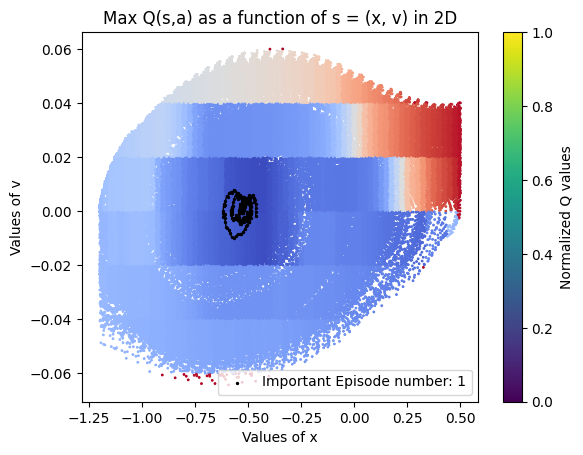

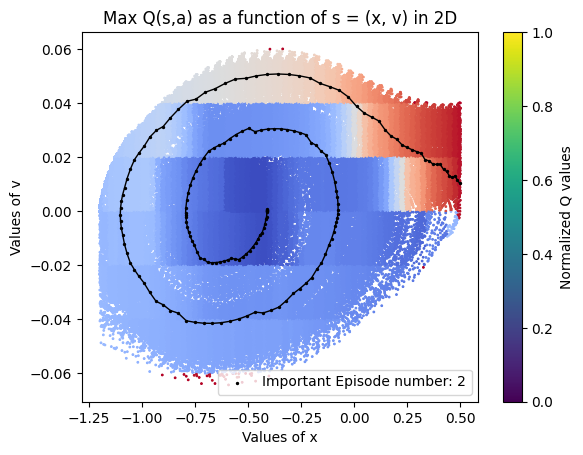

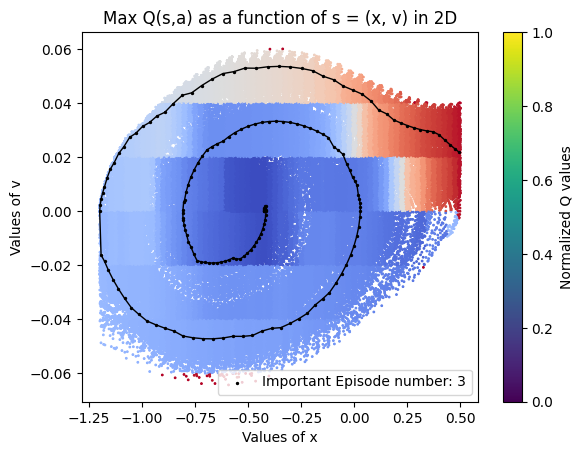

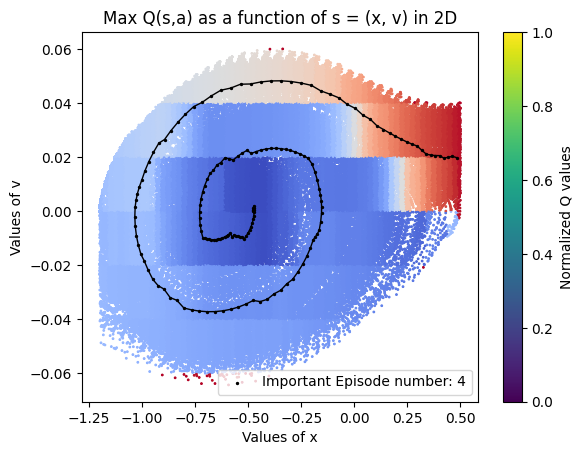

KeyboardInterrupt: 

In [18]:
A.two_dimensions_Q_plot(with_important_episodes = True)

In [19]:
A.three_dimensions_Q_plot(with_important_episodes = True)

ValueError: Invalid property specified for object of type plotly.graph_objs.scatter3d.marker.ColorBar: 'height'

Did you mean "dtick"?

    Valid properties:
        bgcolor
            Sets the color of padded area.
        bordercolor
            Sets the axis line color.
        borderwidth
            Sets the width (in px) or the border enclosing this
            color bar.
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        labelalias
            Replacement text for specific tick or hover labels. For
            example using {US: 'USA', CA: 'Canada'} changes US to
            USA and CA to Canada. The labels we would have shown
            must match the keys exactly, after adding any
            tickprefix or ticksuffix. For negative numbers the
            minus sign symbol used (U+2212) is wider than the
            regular ascii dash. That means you need to use −1
            instead of -1. labelalias can be used with any axis
            type, and both keys (if needed) and values (if desired)
            can include html-like tags or MathJax.
        len
            Sets the length of the color bar This measure excludes
            the padding of both ends. That is, the color bar length
            is this length minus the padding on both ends.
        lenmode
            Determines whether this color bar's length (i.e. the
            measure in the color variation direction) is set in
            units of plot "fraction" or in *pixels. Use `len` to
            set the value.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        orientation
            Sets the orientation of the colorbar.
        outlinecolor
            Sets the axis line color.
        outlinewidth
            Sets the width (in px) of the axis line.
        separatethousands
            If "true", even 4-digit integers are separated
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        thickness
            Sets the thickness of the color bar This measure
            excludes the size of the padding, ticks and labels.
        thicknessmode
            Determines whether this color bar's thickness (i.e. the
            measure in the constant color direction) is set in
            units of plot "fraction" or in "pixels". Use
            `thickness` to set the value.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the color bar's tick label font
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.scatter3d.marke
            r.colorbar.Tickformatstop` instances or dicts with
            compatible properties
        tickformatstopdefaults
            When used in a template (as layout.template.data.scatte
            r3d.marker.colorbar.tickformatstopdefaults), sets the
            default property values to use for elements of
            scatter3d.marker.colorbar.tickformatstops
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. In other cases the default is *hide past
            div*.
        ticklabelposition
            Determines where tick labels are drawn relative to the
            ticks. Left and right options are used when
            `orientation` is "h", top and bottom when `orientation`
            is "v".
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.scatter3d.marker.colorbar.
            Title` instance or dict with compatible properties
        titlefont
            Deprecated: Please use
            scatter3d.marker.colorbar.title.font instead. Sets this
            color bar's title font. Note that the title's font used
            to be set by the now deprecated `titlefont` attribute.
        titleside
            Deprecated: Please use
            scatter3d.marker.colorbar.title.side instead.
            Determines the location of color bar's title with
            respect to the color bar. Defaults to "top" when
            `orientation` if "v" and  defaults to "right" when
            `orientation` if "h". Note that the title's location
            used to be set by the now deprecated `titleside`
            attribute.
        x
            Sets the x position with respect to `xref` of the color
            bar (in plot fraction). When `xref` is "paper",
            defaults to 1.02 when `orientation` is "v" and 0.5 when
            `orientation` is "h". When `xref` is "container",
            defaults to 1 when `orientation` is "v" and 0.5 when
            `orientation` is "h". Must be between 0 and 1 if `xref`
            is "container" and between "-2" and 3 if `xref` is
            "paper".
        xanchor
            Sets this color bar's horizontal position anchor. This
            anchor binds the `x` position to the "left", "center"
            or "right" of the color bar. Defaults to "left" when
            `orientation` is "v" and "center" when `orientation` is
            "h".
        xpad
            Sets the amount of padding (in px) along the x
            direction.
        xref
            Sets the container `x` refers to. "container" spans the
            entire `width` of the plot. "paper" refers to the width
            of the plotting area only.
        y
            Sets the y position with respect to `yref` of the color
            bar (in plot fraction). When `yref` is "paper",
            defaults to 0.5 when `orientation` is "v" and 1.02 when
            `orientation` is "h". When `yref` is "container",
            defaults to 0.5 when `orientation` is "v" and 1 when
            `orientation` is "h". Must be between 0 and 1 if `yref`
            is "container" and between "-2" and 3 if `yref` is
            "paper".
        yanchor
            Sets this color bar's vertical position anchor This
            anchor binds the `y` position to the "top", "middle" or
            "bottom" of the color bar. Defaults to "middle" when
            `orientation` is "v" and "bottom" when `orientation` is
            "h".
        ypad
            Sets the amount of padding (in px) along the y
            direction.
        yref
            Sets the container `y` refers to. "container" spans the
            entire `height` of the plot. "paper" refers to the
            height of the plotting area only.
        
Did you mean "dtick"?

Bad property path:
height
^^^^^^

In [35]:
Dyna_Test = DynaAgent("idTest", env=gym.make('MountainCar-v0', render_mode='human'))
Dyna_Test.Q = A.Q
episodesHistory = Dyna_Test.play(seed = False)

72
[0.6  0.07]
[-1.2  -0.07]
7
476
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
2
2
2
2
2
2
0
0
0
0
0
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
2
2
1
1
1
1
2
2
2
2
2
2
2
2
2
2
0
2
1
2
1
2
0
2
2
2
2
2
2
2
2
2
1
2
2
1
2
1
2
2
2
2
2
2
2
2
2
2


In [5]:
def variation_size_bins_plot(coeff, number_points, number_train_for_each_point, change_for_x=False, change_for_v=False, mult=False, div=False):


    """
    Cette fonction trace les plots avec :
    - en abscisse le nombre d'épisodes par pas de 50
    - en ordonnée, soit le x, soit le v maximal (ou minimal) atteint tous les 50 épisodes 
    (pour un total de 4 plots donc)
    
    """
    
    discr_step_ref = np.array([0.025, 0.005])

    X_plot = np.arange(0, number_points*number_train_for_each_point, number_train_for_each_point)
    
    Y_max_x_episodes = []
    Y_min_x_episodes = []

    Y_max_v_episodes = []
    Y_min_v_episodes = []

    if change_for_x:
        if mult:
            discr_step_ref[0]*=coeff
        else:
            if div:
                discr_step_ref[0]/=coeff
            
    if change_for_v:
        if mult:
            discr_step_ref[1]*=coeff
        else :
            if div:
                discr_step_ref[1]/=coeff

    # print(discr_step_ref)
    Dyn = DynaAgent("idPlot", discr_step = discr_step_ref)
    print((Dyn.n_xbins, Dyn.n_vbins))

    for _ in range(number_points):

        Dyn.train(number_train_for_each_point) # nombre d'étapes avant de regarder l'état max atteint

        print(Y_max_x_episodes)
        Y_max_x_episodes.append(Dyn.max_x)
        Y_min_x_episodes.append(Dyn.min_x)

        Y_max_v_episodes.append(Dyn.max_v)
        Y_min_v_episodes.append(Dyn.min_v)

    return (X_plot,  Y_max_x_episodes, Y_max_v_episodes,  Y_min_x_episodes,  Y_min_v_episodes)
    


    

In [20]:
(X_plot,  Y_max_x_episodes, Y_max_v_episodes,  Y_min_x_episodes,  Y_min_v_episodes) = variation_size_bins_plot(2, 10, 5, change_for_x=True, change_for_v=True, mult=True)


fig, ((ax1a, ax1b), (ax2a, ax2b)) = plt.subplots(2, 2)

ax1a.plot(X_plot, Y_max_x_episodes)
ax1a.set_xlabel(r'Number of episode')
ax1a.set_ylabel(r'Max x reached')
ax1a.set_title(r'Farthest x reached by number of episodes')  

ax1b.plot(X_plot, Y_min_x_episodes)
ax1b.set_xlabel(r'Number of episode')
ax1b.set_ylabel(r'Min x reached')
ax1b.set_title(r'Smallest x reached by number of episodes') 

ax2a.plot(X_plot, Y_max_v_episodes)
ax2a.set_xlabel(r'Number of episode')
ax2a.set_ylabel(r'Max v reached')
ax2a.set_title(r'Farthest v reached by number of episodes')  


ax2b.plot(X_plot, Y_min_v_episodes)
ax2b.set_xlabel(r'Number of episode')
ax2b.set_ylabel(r'Min v reached')
ax2b.set_title(r'Smallest v reached by number of episodes') 

plt.tight_layout()
plt.subplots_adjust(wspace=2, hspace=0.5)

plt.show()

NameError: name 'variation_size_bins_plot' is not defined

In [21]:
(X_plot,  Y_max_x_episodes, Y_max_v_episodes,  Y_min_x_episodes,  Y_min_v_episodes) = variation_size_bins_plot(2, 10, 5, change_for_x=True, change_for_v=True, div=True)


fig, ((ax1a, ax1b), (ax2a, ax2b)) = plt.subplots(2, 2)

ax1a.plot(X_plot, Y_max_x_episodes)
ax1a.set_xlabel(r'Number of episode')
ax1a.set_ylabel(r'Max x reached')
ax1a.set_title(r'Farthest x reached by number of episodes')  

ax1b.plot(X_plot, Y_min_x_episodes)
ax1b.set_xlabel(r'Number of episode')
ax1b.set_ylabel(r'Min x reached')
ax1b.set_title(r'Smallest x reached by number of episodes') 

ax2a.plot(X_plot, Y_max_v_episodes)
ax2a.set_xlabel(r'Number of episode')
ax2a.set_ylabel(r'Max v reached')
ax2a.set_title(r'Farthest v reached by number of episodes')  


ax2b.plot(X_plot, Y_min_v_episodes)
ax2b.set_xlabel(r'Number of episode')
ax2b.set_ylabel(r'Min v reached')
ax2b.set_title(r'Smallest v reached by number of episodes') 

plt.tight_layout()
plt.subplots_adjust(wspace=2, hspace=0.5)

plt.show()

NameError: name 'variation_size_bins_plot' is not defined

In [22]:
def plot_time_duration_episodes(time_episodes):

    X = np.arange(1, len(time_episodes)+1, 1)
    T = np.array(time_episodes)

    fig, ax = plt.subplots(1,1)
    ax.scatter(X, T, marker='.')
    ax.set_title('Evolution of episode duration')
    ax.set_xlabel(r'Episode number')
    ax.set_ylabel(r'Episode duration')
    plt.grid(color='black', which="both")
    plt.plot()
    

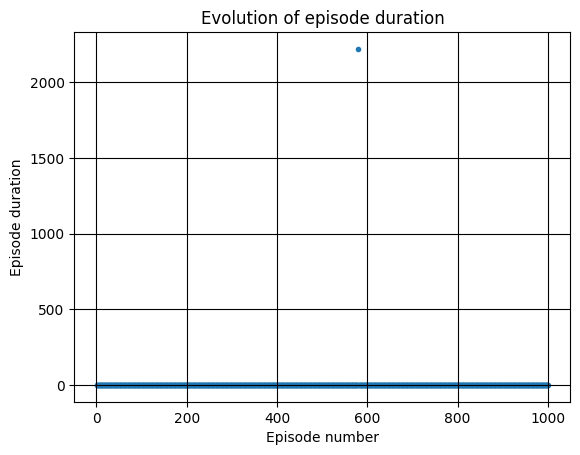

In [23]:
plot_time_duration_episodes(A.time_episodes)

In [24]:
def accumulated_to_index(epList):
    tot_ep = len(epList)
    return [np.sum(epList[:nb_ep]) for nb_ep in range(tot_ep)]



def plot_rewards(episodesHistory, auxiliary_reward):

    nb_episodes = len(episodesHistory)
    T = np.arange(1, nb_episodes+1, 1)
    
    fig1,ax1 = plt.subplots(1,1)
    ax1.plot(T, episodesHistory, marker='.')
    ax1.set_title(f'Total environment reward per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Total environment reward')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')

    fig2,ax2 = plt.subplots(1,1)
    ax2.plot(T, auxiliary_reward, marker='.')
    ax2.set_title(f'Total auxiliary reward per episode')
    ax2.set_xlabel(r'Episode number')
    ax2.set_ylabel(r'Total environment reward')
    ax2.set_xscale('linear')
    ax2.set_yscale('linear')

    accumulated_episodesHistory = accumulated_to_index(episodesHistory)
    accumulated_auxiliary_reward = accumulated_to_index(auxiliary_reward)

    fig3,ax3 = plt.subplots(1,1)
    ax3.plot(T, accumulated_episodesHistory, marker='.')
    ax3.set_title(f'Total accumulated environment reward per episode')
    ax3.set_xlabel(r'Episode number')
    ax3.set_ylabel(r'Total accumulated environment reward')
    ax3.set_xscale('linear')
    ax3.set_yscale('linear')

    fig4,ax4 = plt.subplots(1,1)
    ax4.plot(T, accumulated_auxiliary_reward, marker='.')
    ax4.set_title(f'Total accumulated auxiliary reward per episode')
    ax4.set_xlabel(r'Episode number')
    ax4.set_ylabel(r'Total accumulated environment reward')
    ax4.set_xscale('linear')
    ax4.set_yscale('linear')

    

    

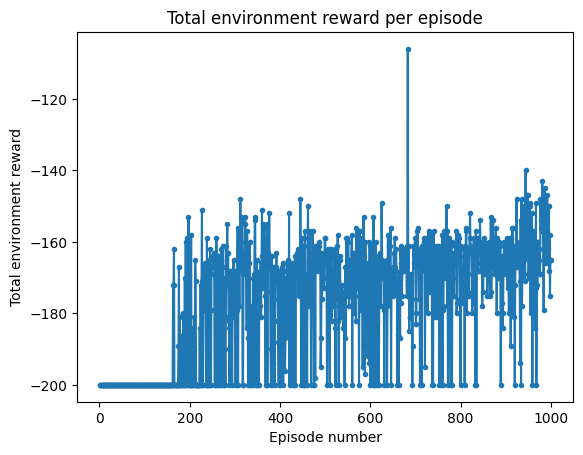

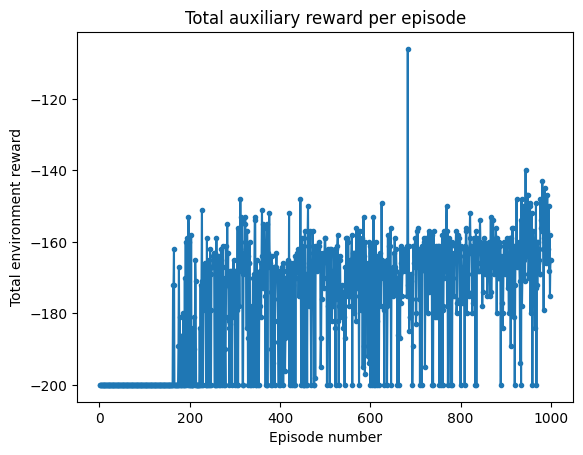

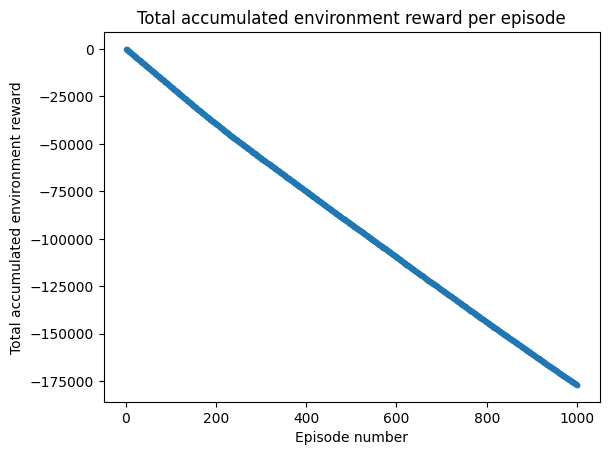

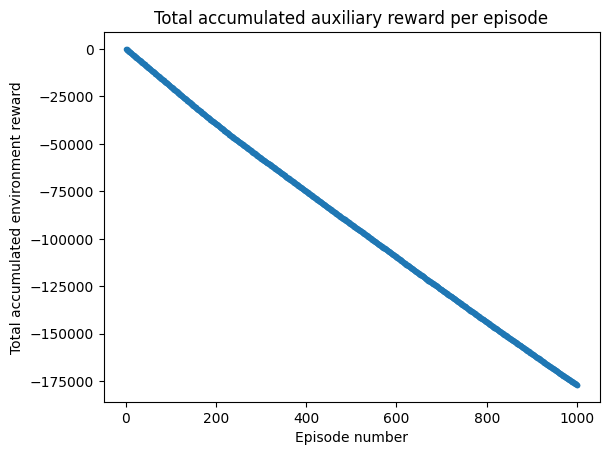

In [25]:
plot_rewards(A.episodesHistory, A.auxiliary_reward)

In [26]:
def cumulative_number_of_successes(success_episodes):
    
    nb_ep = len(success_episodes)
    cumulative_success = [np.sum(success_episodes[:ep]) for ep in range(nb_ep)]

    fig1,ax1 = plt.subplots(1,1)
    ax1.scatter(range(nb_ep), cumulative_success, marker='.')
    ax1.set_title('Cumulative number of successes per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Cumulative number of successes')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    

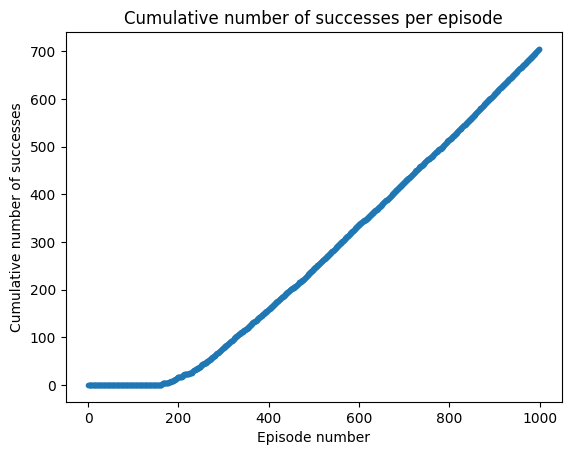

In [27]:
cumulative_number_of_successes(A.success_episodes)

In [28]:
def mean_Q_evol(mean_Q_evolution):
    
    nb_ep = len(mean_Q_evolution)
    
    fig1,ax1 = plt.subplots(1,1)
    ax1.plot(range(nb_ep), mean_Q_evolution)
    ax1.set_title('Average max_Q per episode')
    ax1.set_xlabel(r'Episode number')
    ax1.set_ylabel(r'Average max_Q')
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    

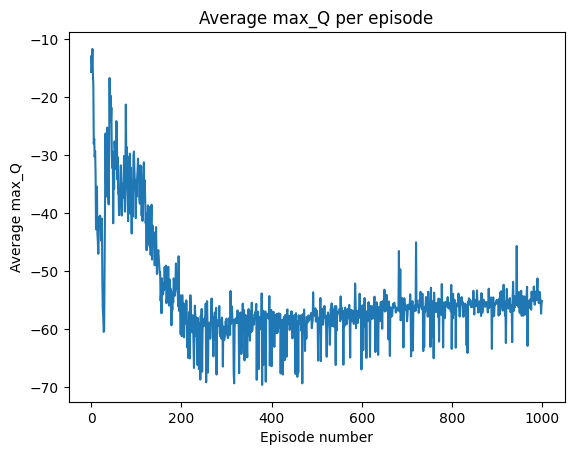

In [29]:
mean_Q_evol(A.mean_Q_evolution)